<h1 align="center"><strong>Projet</h3> <h1 align="center">Classification binaire</strong></h3> 

## Introduction
L'entreprise TouNum souhaite automatiser la sélection de photos pour l'annotation. Ce livrable présente une méthode de classification basée sur des réseaux de neurones afin de filtrer les images qui ne sont pas des photos dans le dataset de départ. La solution s'appuie sur une architecture de réseau de neurones justifiée par les résultats obtenus.

## Contexte
TouNum travaille sur la numérisation de documents et souhaite étendre ses services pour inclure des outils de Machine Learning. Avec une grande quantité de données à numériser, un service de catégorisation automatique est essentiel. Ce projet vise à développer un modèle capable de distinguer les photos des autres types d'images, comme les schémas ou les textes scannés.

## Objectifs
- Développer un modèle de classification binaire pour identifier les photos.
- Utiliser des réseaux de neurones pour améliorer la précision de la classification.
- Analyser les résultats et proposer des améliorations potentielles.

On importe les librairies nécessaires

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import visualkeras

import os
import shutil
from sklearn.metrics import precision_score, recall_score, f1_score
import json

In [51]:
tf.__version__

'2.15.0'

In [52]:
data_dir = 'Dataset'

In [53]:
data_dir

'Dataset'

### On définit les paramètres de l'image et du batch, ainsi que la validation
- **image_h** = 180  : Hauteur de l'image en pixels, choisi pour un bon compromis entre détails et performance.
- **image_w** = 180  : Largeur de l'image en pixels, même justification que pour la hauteur.
- **batch_s** sera égale à 16 ou 32   : Taille du batch, choisie pour optimiser l'utilisation de la mémoire et la vitesse d'entraînement.
- **validation_split** = 0.2  : Proportion des données réservées pour la validation, permettant d'évaluer le modèle sur des données non vues.

In [54]:
image_h = 200
image_w = 200
batch_s = 64
validation_split = 0.2

<div>
    <h3>Chargement du jeu de données d'entraînement</h3>
    <p>
        <code>train_set</code> est créé à partir des images dans le répertoire spécifié par <code>data_dir</code>. 
        Les paramètres utilisés sont les suivants :
    </p>
    <ul>
        <li><strong>image_size</strong>: (image_h, image_w) - Dimensions des images (180x180 pixels).</li>
        <li><strong>batch_size</strong>: batch_s - Taille du lot d'images (16).</li>
        <li><strong>seed</strong>: 123 - Graine pour la reproductibilité.</li>
        <li><strong>validation_split</strong>: validation_split - Proportion des données pour la validation (20%).</li>
        <li><strong>subset</strong>: 'training' - Indique que ce sous-ensemble est pour l'entraînement.</li>
    </ul>
</div>

In [55]:
train_set = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                         image_size=(image_h, image_w),
                                                         batch_size=batch_s,
                                                         seed=123,
                                                         validation_split=validation_split,
                                                         subset='training')

Found 41398 files belonging to 5 classes.
Using 33119 files for training.


<div>
    <h3>Chargement du jeu de données de validation</h3>
    <p>
        <code>val_set</code> est créé à partir des images dans le répertoire spécifié par <code>data_dir</code>. 
        Les paramètres utilisés sont les suivants :
    </p>
    <ul>
        <li><strong>image_size</strong>: (image_h, image_w) - Dimensions des images (180x180 pixels).</li>
        <li><strong>batch_size</strong>: batch_s - Taille du lot d'images (16).</li>
        <li><strong>seed</strong>: 123 - Graine pour la reproductibilité.</li>
        <li><strong>validation_split</strong>: validation_split - Proportion des données pour la validation (20%).</li>
        <li><strong>subset</strong>: 'validation' - Indique que ce sous-ensemble est pour la validation.</li>
    </ul>
</div>



In [56]:
val_set = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                      image_size=(image_h, image_w),
                                                      batch_size=batch_s,
                                                      seed=123,
                                                      validation_split=validation_split,
                                                      subset='validation')

Found 41398 files belonging to 5 classes.
Using 8279 files for validation.


<div>
    <h3>Récupération des noms de classes</h3>
    <p>
        <code>class_names</code> est une liste qui contient les noms des classes d'images présents dans le jeu de données d'entraînement. 
        Cela permet d'identifier les différentes catégories lors de l'entraînement et de l'évaluation du modèle.
    </p>
</div>

In [57]:
class_names = train_set.class_names
class_names

['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']

<div>
    <h3>Affichage d'échantillons d'images</h3>
    <p>
        Ce code permet d'afficher un échantillon de 9 images du jeu de données d'entraînement. 
        Chaque image est accompagnée de son titre correspondant, qui indique la classe à laquelle elle appartient.
    </p>
</div>

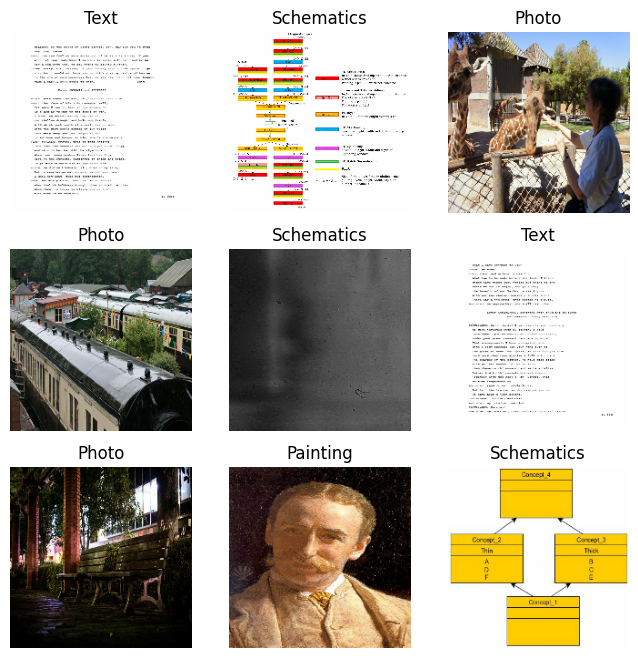

In [58]:
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

In [59]:
images, labels = next(iter(train_set))  # Récupère le premier batch du jeu d'entraînement
print(images.shape)  # Affiche la forme du tenseur des images
print(labels.shape)  # Affiche la forme du tenseur des labels

(64, 200, 200, 3)
(64,)


<div>
    <h3>Optimisation des performances des jeux de données</h3>
    <p>
        Ce code utilise plusieurs techniques pour optimiser le traitement des jeux de données d'entraînement et de validation. Ces optimisations sont cruciales pour améliorer la vitesse d'entraînement et l'efficacité du modèle. Voici les techniques mises en œuvre :
    </p>
    <ul>
        <li>
            <strong>Mise en cache :</strong> 
            <p>
                La mise en cache permet de stocker les données en mémoire après leur première lecture. Cela réduit le temps d'accès aux données lors des itérations suivantes, car les données n'ont pas besoin d'être rechargées depuis le disque. Cela est particulièrement utile lorsque le même ensemble de données est utilisé plusieurs fois pendant l'entraînement.
            </p>
        </li>
        <li>
            <strong>Mélange (Shuffle) :</strong> 
            <p>
                Le mélange des données avant l'entraînement aide à éviter que le modèle n'apprenne des séquences spécifiques dans les données. En randomisant l'ordre des échantillons, on s'assure que le modèle généralise mieux et ne s'adapte pas uniquement à l'ordre des données d'entraînement.
            </p>
        </li>
        <li>
            <strong>Préchargement (Prefetch) :</strong> 
            <p>
                Le préchargement permet de préparer les données pour le prochain lot pendant que le modèle est en cours d'entraînement sur le lot actuel. Cela réduit le temps d'attente entre les itérations, car les données sont déjà prêtes à être utilisées lorsque le modèle a terminé de traiter le lot précédent.
            </p>
        </li>
    </ul>
    <p>
        En combinant ces techniques, nous pouvons significativement améliorer la vitesse d'entraînement et réduire le temps d'attente pour le chargement des données, ce qui est essentiel pour un développement efficace de modèles de machine learning.
    </p>
</div>

In [60]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)


<div>
    <h3>Définition du modèle</h3>
    <p>
        <code>num_classes</code> représente le nombre total de classes dans le jeu de données, ce qui détermine également le nombre de neurones dans la dernière couche du modèle. 
        Le modèle est initialisé en tant que modèle séquentiel, permettant d'ajouter des couches de manière linéaire.
    </p>
</div>



In [61]:
num_classes = len(class_names) # Nombre de classes et donc aussi nombre de neurones dans la dernière couche
num_classes


5

<div>
    <h3>Définition du taux de dropout</h3>
    <p>
        Le <code>dropout</code> est une technique de régularisation utilisée pour prévenir le surapprentissage (overfitting) dans les modèles de réseaux de neurones. 
        Cette méthode consiste à désactiver aléatoirement un certain pourcentage de neurones pendant l'entraînement, ce qui empêche le modèle de devenir trop dépendant de certaines caractéristiques des données d'entraînement.
    </p>
    <p>
        Par exemple, un taux de <code>0.2</code> signifie que 20% des neurones seront désactivés à chaque itération. Cela force le modèle à apprendre des représentations plus robustes et généralisables, car il ne peut pas s'appuyer sur des neurones spécifiques pour faire des prédictions.
    </p>
    <p>
        L'utilisation du dropout est particulièrement bénéfique dans les architectures de réseaux de neurones profonds, où le risque de surapprentissage est plus élevé en raison du grand nombre de paramètres. En désactivant aléatoirement des neurones, le modèle est encouragé à explorer différentes combinaisons de caractéristiques, ce qui améliore sa capacité à généraliser sur des données non vues.
    </p>
    <p>
        En résumé, le dropout est une technique essentielle pour améliorer la performance des modèles de machine learning, en réduisant le risque de surapprentissage et en favorisant une meilleure généralisation.
    </p>
</div>

In [40]:
dropout = 0.5

<div>
    <h3>Construction du modèle de réseau de neurones convolutif</h3>
    <p>
        Ce modèle commence par normaliser les pixels des images en les mettant à l'échelle entre 0 et 1. Cette étape est cruciale car elle permet d'améliorer la convergence du modèle pendant l'entraînement, en assurant que toutes les valeurs d'entrée sont sur une échelle similaire.
    </p>
    <p>
        Ensuite, plusieurs blocs convolutifs sont ajoutés, chacun avec un certain nombre de filtres et une activation ReLU. Ces blocs sont suivis d'une opération de sous-échantillonnage (MaxPooling), qui réduit la dimensionnalité des caractéristiques extraites tout en conservant les informations les plus importantes.
    </p>
    <ul>
        <li>
            <strong>Rescaling</strong>: Normalisation des valeurs de pixel pour les amener dans la plage [0, 1]. Cela aide à stabiliser l'apprentissage.
        </li>
        <li>
            <strong>Conv2D</strong>: Ajout de couches convolutives avec 16, 32 et 64 filtres respectivement. Chaque filtre apprend à détecter des caractéristiques spécifiques dans les images, comme des bords ou des textures.
        </li>
        <li>
            <strong>MaxPooling2D</strong>: Réduction de la dimensionnalité des caractéristiques extraites. Cela permet de diminuer le nombre de paramètres et de calculs dans le réseau, tout en préservant les caractéristiques les plus significatives.
        </li>
          <li>
            <strong>AveragePooling</strong>: est une technique de sous-échantillonnage utilisée dans les réseaux de neurones convolutifs. Contrairement à MaxPooling, qui prend la valeur maximale dans une fenêtre de pooling, AveragePooling calcule la moyenne des valeurs dans cette fenêtre. Cela permet de conserver une représentation plus douce des caractéristiques, ce qui peut être bénéfique dans certains cas, notamment lorsque l'on souhaite réduire le bruit dans les données.
        </li>
        <li>
            <strong>Flatten</strong>: Aplatissement des données pour les couches denses. Cette étape transforme les données 2D en un vecteur 1D, ce qui est nécessaire pour les couches entièrement connectées.
        </li>
        <li>
            <strong>Dense</strong>: Couche entièrement connectée avec 128 neurones et activation ReLU. Cette couche apprend des combinaisons non linéaires des caractéristiques extraites par les couches précédentes.
        </li>
        <li>
            <strong>Dropout</strong>: Application de la régularisation avec un taux de 20% pour éviter le surapprentissage. Cela désactive aléatoirement 20% des neurones pendant l'entraînement, ce qui aide à généraliser le modèle.
        </li>
        <li>
            <strong>Dense</strong>: Couche de sortie avec activation softmax pour la classification des classes. Cette couche produit des probabilités pour chaque classe, permettant au modèle de faire des prédictions sur les nouvelles images.
        </li>
    </ul>
    <p>
        En combinant ces éléments, le modèle est capable d'apprendre des représentations complexes des données d'entrée, ce qui est essentiel pour des tâches de classification d'images.
    </p>
</div>

In [63]:
model = Sequential([
    layers.Rescaling(1/255, input_shape=(image_h, image_w, 3)),
    
    # Bloc convolutif ou la taille du filtre est de (16, 3)
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    # Bloc convolutif ou la taille du filtre est de (32, 3)
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    # Bloc convolutif ou la taille du filtre est de (64, 3)
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    # Applatissement de la couche
    layers.Flatten(),
    
    # Couche entièrement connectée (couche dense)
    layers.Dense(128, activation='relu'),
    layers.Dropout(dropout),
    
    # Couche entièrement connectée retournant le résultat de la classification
    layers.Dense(num_classes, activation='softmax')
])

<div>
    <h3>Compilation du modèle</h3>
    <p>
        La compilation du modèle est une étape cruciale qui prépare le modèle à l'entraînement. Elle définit les paramètres essentiels qui guideront l'apprentissage du modèle. Le modèle est compilé avec les paramètres suivants :
    </p>
    <ul>
        <li>
            <strong>Optimiseur</strong>: <code>adam</code> - Un optimiseur populaire qui ajuste les taux d'apprentissage pour chaque paramètre. L'optimiseur Adam combine les avantages de deux autres extensions de la descente de gradient, à savoir AdaGrad et RMSProp. Il est particulièrement efficace pour les problèmes avec de grandes quantités de données et de nombreux paramètres, car il adapte le taux d'apprentissage en fonction des moments des gradients.
        </li>
        <li>
            <strong>Fonction de perte</strong>: <code>SparseCategoricalCrossentropy</code> - Utilisée pour les problèmes de classification multi-classes. Cette fonction de perte mesure la distance entre les distributions de probabilité prédites par le modèle et les vraies étiquettes. L'option <code>from_logits=True</code> indique que les sorties du modèle ne sont pas normalisées, ce qui signifie que le modèle produit des valeurs brutes (logits) avant l'application de la fonction softmax.
        </li>
        <li>
            <strong>Métriques</strong>: <code>accuracy</code> - Mesure de la précision du modèle lors de l'évaluation. La précision est le rapport entre le nombre de prédictions correctes et le nombre total de prédictions. C'est une métrique essentielle pour évaluer la performance d'un modèle de classification, car elle donne une indication claire de la capacité du modèle à faire des prédictions correctes.
        </li>
    </ul>
    <p>
        En résumé, la compilation du modèle est une étape fondamentale qui définit comment le modèle apprendra à partir des données d'entraînement. Le choix de l'optimiseur, de la fonction de perte et des métriques a un impact significatif sur la performance et l'efficacité de l'apprentissage.
    </p>
</div>

In [64]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

<div>
    <h3>Résumé du modèle</h3>
    <p>
        La méthode <code>model.summary()</code> fournit un aperçu détaillé de la structure du modèle, y compris :
    </p>
    <ul>
        <li>Les différentes couches du modèle.</li>
        <li>Les formes de sortie de chaque couche.</li>
        <li>Le nombre total de paramètres, ainsi que le nombre de paramètres entraînables et non entraînables.</li>
    </ul>
</div>


In [65]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_25 (Rescaling)    (None, 200, 200, 3)       0         
                                                                 
 conv2d_75 (Conv2D)          (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_75 (MaxPooli  (None, 100, 100, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_76 (Conv2D)          (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_76 (MaxPooli  (None, 50, 50, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_77 (Conv2D)          (None, 50, 50, 64)      

<div>
    <h3>Entraînement du modèle</h3>
    <p>
        Le modèle est entraîné sur le jeu de données d'entraînement pendant un nombre défini d'époques. 
        Les paramètres clés incluent :
    </p>
    <ul>
        <li><strong>epochs</strong>: Nombre d'époques fixé à 10.</li>
        <li><strong>validation_data</strong>: Utilisation du jeu de validation pour évaluer la performance du modèle.</li>
        <li>
            <strong>EarlyStopping</strong>: 
            <p>
                Ce callback permet d'arrêter l'entraînement si la perte de validation ne s'améliore pas pendant un certain nombre d'époques consécutives, ici fixé à 3. Cela aide à prévenir le surapprentissage (overfitting) en évitant que le modèle ne continue à s'entraîner sur des données qui ne montrent plus d'amélioration. 
                En outre, l'option <code>restore_best_weights=True</code> permet de restaurer les poids du modèle à l'état où la perte de validation était la plus faible, garantissant ainsi que le modèle final est le meilleur possible en termes de performance sur les données de validation.
            </p>
        </li>
    </ul>
    <p>
        Les métriques d'entraînement et de validation (précision et perte) sont ensuite récupérées pour analyse.
    </p>
</div>

In [66]:
epochs = 10
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

Epoch 1/10


C:\Users\Téo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


518/518 [==============================] - 305s 287ms/step - loss: 0.6937 - accuracy: 0.7155 - val_loss: 0.4031 - val_accuracy: 0.8435
Epoch 2/10
518/518 [==============================] - 128s 247ms/step - loss: 0.4099 - accuracy: 0.8357 - val_loss: 0.3500 - val_accuracy: 0.8565
Epoch 3/10
518/518 [==============================] - 136s 263ms/step - loss: 0.3454 - accuracy: 0.8659 - val_loss: 0.3543 - val_accuracy: 0.8680
Epoch 4/10
518/518 [==============================] - 148s 285ms/step - loss: 0.2966 - accuracy: 0.8850 - val_loss: 0.2906 - val_accuracy: 0.8918
Epoch 5/10
518/518 [==============================] - 145s 281ms/step - loss: 0.2489 - accuracy: 0.9047 - val_loss: 0.2678 - val_accuracy: 0.9008
Epoch 6/10
518/518 [==============================] - 181s 349ms/step - loss: 0.2195 - accuracy: 0.9154 - val_loss: 0.3030 - val_accuracy: 0.8939
Epoch 7/10
518/518 [==============================] - 164s 316ms/step - loss: 0.1878 - accuracy: 0.9284 - val_loss: 0.2875 - val_accura

<div>
    <h3>Récupération des métriques d'entraînement et de validation</h3>
    <p>
        Après l'entraînement du modèle, il est crucial d'extraire et d'analyser les métriques d'entraînement et de validation. 
        Ces métriques permettent de suivre la performance du modèle au fil des époques et d'évaluer son efficacité à généraliser sur des données non vues.
    </p>
    <p>
        Les métriques suivantes sont récupérées à partir de l'historique de l'entraînement :
    </p>
    <ul>
        <li><strong>acc</strong>: Précision d'entraînement, qui indique la proportion de prédictions correctes sur le jeu de données d'entraînement.</li>
        <li><strong>val_acc</strong>: Précision de validation, qui mesure la performance du modèle sur le jeu de validation.</li>
        <li><strong>loss</strong>: Perte d'entraînement, qui quantifie l'erreur du modèle sur le jeu de données d'entraînement.</li>
        <li><strong>val_loss</strong>: Perte de validation, qui évalue l'erreur du modèle sur le jeu de validation.</li>
    </ul>
</div>

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

<div>
    <h3>Affichage des graphiques de performance</h3>
    <p>
        Ce code génère et affiche deux graphiques :
    </p>
    <ul>
        <li><strong>Précision d'entraînement et de validation</strong>: Montre comment la précision évolue au fil des époques.</li>
        <li><strong>Perte d'entraînement et de validation</strong>: Montre l'évolution de la perte au fil des époques.</li>
    </ul>
    <p>
        Les graphiques sont sauvegardés dans un fichier PNG avec un nom qui inclut des paramètres du modèle pour une identification facile.
    </p>
</div>


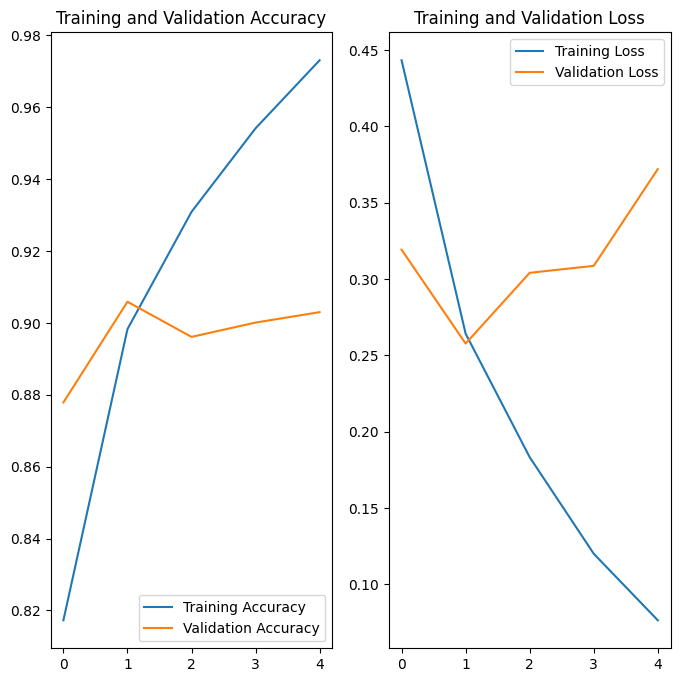

In [19]:
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig(f'CNN Graphique/CNN_K3x3_IM{image_h}x{image_w}_B{batch_s}_VS{int(validation_split * 100)}_DO{int(dropout * 100)}_E{len(acc)}.png')

plt.show()

### Analyse du Graphique

#### 1. Précision d'Entraînement et de Validation
- La courbe de précision d'entraînement (en bleu) montre une tendance à la hausse, atteignant presque 0,98, ce qui indique que le modèle s'améliore bien sur les données d'entraînement.
- La courbe de précision de validation (en orange) augmente également, mais à un rythme plus lent et semble se stabiliser autour de 0,90. Cela suggère que le modèle généralise bien, mais qu'il y a un léger écart par rapport à l'entraînement.

#### 2. Perte d'Entraînement et de Validation
- La courbe de perte d'entraînement (en bleu) diminue de manière constante, ce qui est un bon signe, car cela indique que le modèle apprend à minimiser l'erreur sur les données d'entraînement.
- La courbe de perte de validation (en orange) montre une tendance à la baisse, mais elle fluctue davantage, ce qui peut indiquer une certaine instabilité dans la généralisation du modèle.

### Conclusion
- **Surapprentissage** : Il n'y a pas de signes évidents de surapprentissage (overfitting) dans ce graphique, car la précision de validation ne diminue pas alors que la précision d'entraînement augmente. Cependant, la perte de validation qui fluctue pourrait indiquer que le modèle pourrait bénéficier d'une régularisation supplémentaire ou d'un ajustement des hyperparamètres.
- **Performance Générale** : Dans l'ensemble, le modèle semble bien fonctionner, avec une bonne précision sur les données d'entraînement et de validation. Il pourrait être intéressant d'explorer des techniques supplémentaires pour améliorer la stabilité de la perte de validation, comme le dropout ou l'ajustement des taux d'apprentissage.

### Recommandations
- **Ajustement des Hyperparamètres** : Tester différents taux de dropout ou d'autres optimisateurs pour voir si cela améliore la stabilité de la perte de validation.
- **Augmentation des Données** : Envisager d'utiliser des techniques d'augmentation des données pour enrichir le jeu de données d'entraînement et améliorer la généralisation.
- **Évaluation sur un Ensemble de Test** : Si ce n'est pas déjà fait, évaluer le modèle sur un ensemble de test distinct pour obtenir une mesure finale de sa performance.

<div>
    <h3>Visualisation du modèle de réseau de neurones</h3>
    <p>
        Ce code utilise la bibliothèque <code>visualkeras</code> pour créer une représentation graphique du modèle de réseau de neurones. 
        La visualisation est un outil précieux pour comprendre la structure du modèle et les connexions entre les différentes couches. 
        Cela permet également d'identifier les couches et les paramètres qui peuvent nécessiter des ajustements.
    </p>
    <p>Les étapes incluent :</p>
    <ul>
        <li>
            <strong>Fonction <code>text_callable</code></strong>: 
            <p>
                Cette fonction génère le texte à afficher au-dessus de chaque couche, incluant la forme de sortie et le nom de la couche. 
                Cela permet d'avoir une vue d'ensemble claire de la structure du modèle et des dimensions des données à chaque étape.
            </p>
        </li>
        <li>
            <strong>Calcul de la forme de sortie</strong>: 
            <p>
                La fonction extrait et formate la forme de sortie de chaque couche pour l'affichage. 
                Cela aide à visualiser comment les données évoluent à travers le réseau et à s'assurer que les dimensions sont correctes à chaque étape.
            </p>
        </li>
        <li>
            <strong>Visualisation</strong>: 
            <p>
                La méthode <code>layered_view</code> de <code>visualkeras</code> est utilisée pour créer une image du modèle, qui est ensuite sauvegardée dans un fichier PNG avec des paramètres du modèle dans le nom du fichier. 
                Cette visualisation peut être utilisée pour des présentations ou des rapports, facilitant la communication des résultats et de la structure du modèle.
            </p>
        </li>
    </ul>
    <p>
        En résumé, la visualisation du modèle est une étape importante pour comprendre et communiquer la conception du réseau de neurones, 
        et elle peut également aider à identifier des problèmes potentiels dans l'architecture du modèle.
    </p>
</div>

In [68]:
def text_callable(layer_index, layer):
    # Chaque autre texte est dessiné au-dessus de la couche, le premier en dessous
    above = bool(layer_index % 2)

    # Obtenir la forme de sortie de la couche
    output_shape = [x for x in list(layer.output_shape) if x is not None]

    # Si la forme de sortie est une liste de tuples, nous ne prenons que le premier
    if isinstance(output_shape[0], tuple):
        output_shape = list(output_shape[0])
        output_shape = [x for x in output_shape if x is not None]

    # Variable pour stocker le texte qui sera dessiné    
    output_shape_txt = ""

    # Créer une représentation sous forme de chaîne de la forme de sortie
    for ii in range(len(output_shape)):
        output_shape_txt += str(output_shape[ii])
        if ii < len(output_shape) - 2:  # Ajouter un x entre les dimensions, par ex. 3x3
            output_shape_txt += "x"
        if ii == len(output_shape) - 2:  # Ajouter un saut de ligne entre les deux dernières dimensions, par ex. 3x3 \n 64
            output_shape_txt += "\n"

    # Ajouter le nom de la couche au texte, comme une nouvelle ligne
    output_shape_txt += f"\n{layer.name}"

    # Retourner la valeur du texte et s'il doit être dessiné au-dessus de la couche
    return output_shape_txt, above

C:\Users\Téo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


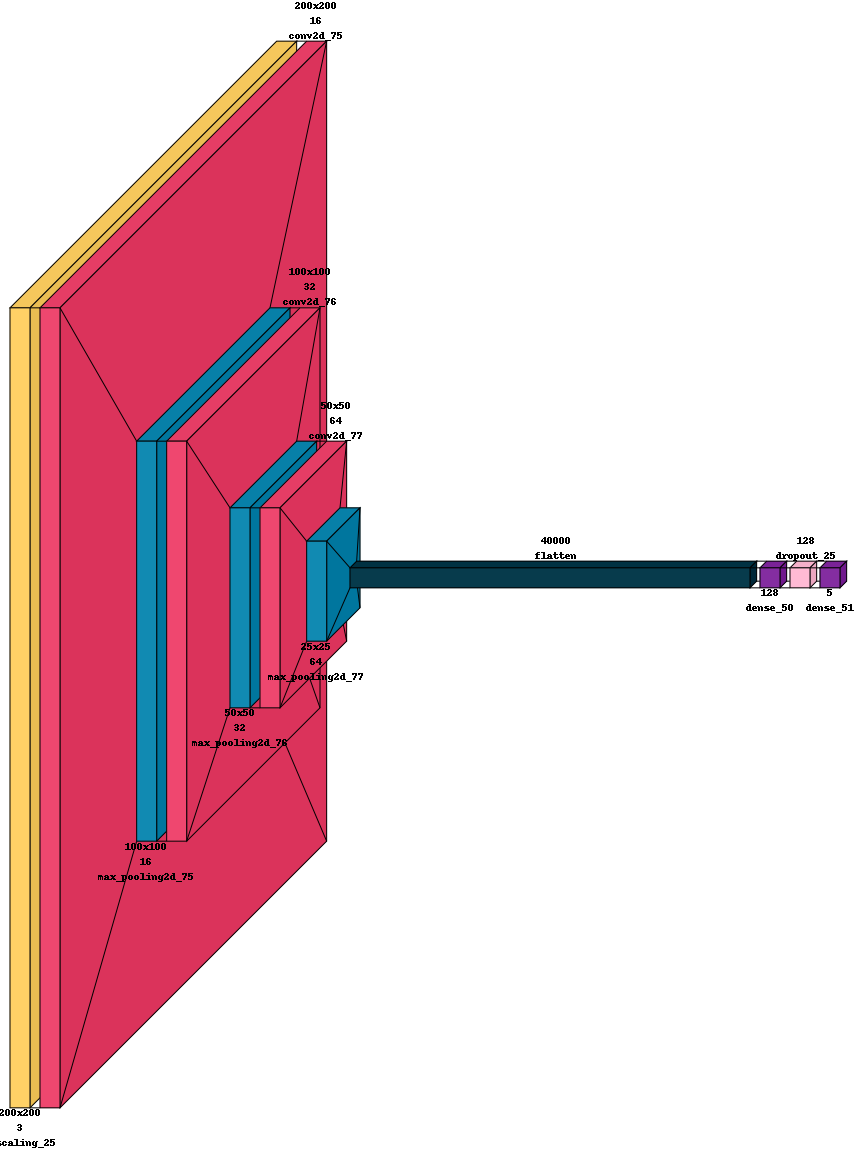

In [69]:
# Visualisation du modèle avec visualkeras
visualkeras.layered_view(model, to_file=f'CNN Representation/CNN_K3x3_IM{image_h}x{image_w}_B{batch_s}_VS{int(validation_split * 100)}_DO{int(dropout * 100)}_E{len(acc)}_test.png', text_callable=text_callable)

<div>
    <h3>Prédiction d'une image</h3>
    <p>
        Ce code charge une image, la redimensionne aux dimensions spécifiées, et effectue une prédiction à l'aide du modèle entraîné. 
        La prédiction est une étape cruciale qui permet d'évaluer la capacité du modèle à généraliser sur de nouvelles données. 
        Les étapes incluent :
    </p>
    <ul>
        <li>
            <strong>Chargement de l'image</strong>: 
            <p>
                L'image est chargée à partir du chemin spécifié et redimensionnée à la taille appropriée (image_h, image_w) pour correspondre à l'entrée du modèle. 
                Cette étape garantit que l'image a les dimensions correctes pour le traitement.
            </p>
        </li>
        <li>
            <strong>Conversion en tableau</strong>: 
            <p>
                L'image est convertie en tableau (tensor) pour être compatible avec le modèle. 
                Cela implique souvent de transformer l'image en un format numérique que le modèle peut traiter, généralement en utilisant des valeurs de pixel normalisées.
            </p>
        </li>
        <li>
            <strong>Prédiction</strong>: 
            <p>
                Le modèle prédit la classe de l'image en utilisant les poids appris lors de l'entraînement. 
                Cette étape génère des logits, qui sont des valeurs brutes représentant les scores pour chaque classe.
            </p>
        </li>
        <li>
            <strong>Softmax</strong>: 
            <p>
                L'application de la fonction softmax convertit les logits en probabilités pour chaque classe. 
                Cela permet d'interpréter les résultats du modèle comme des probabilités, facilitant ainsi la prise de décision sur la classe prédite.
            </p>
        </li>
        <li>
            <strong>Affichage du résultat</strong>: 
            <p>
                Le nom de la classe prédite et la précision associée sont affichés. 
                Cela permet à l'utilisateur de comprendre quelle classe a été prédite par le modèle et avec quel niveau de confiance.
            </p>
        </li>
    </ul>
    <p>
        En résumé, cette procédure de prédiction est essentielle pour évaluer la performance du modèle sur des données non vues et pour appliquer le modèle à des cas d'utilisation réels.
    </p>
</div>

In [21]:
image = 'Texte.png'

In [22]:
image = tf.keras.utils.load_img(image, target_size=(image_h,image_w))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)
predictions = model.predict(img_bat)
score = tf.nn.softmax(predictions[0])
print('Image is {} with accuracy of {:0.2f}'.format(class_names[np.argmax(score)],np.max(score)*100))

1/1 [==============================] - 0s 295ms/step
Image is Schematics with accuracy of 37.48


<div>
    <h3>Sauvegarde du modèle</h3>
    <p>
        Ce code permet de sauvegarder le modèle entraîné dans un fichier au format <code>.keras</code>. 
        La méthode <code>model.save()</code> est utilisée pour enregistrer le modèle avec un nom de fichier qui inclut des paramètres importants, tels que :
    </p>
    <ul>
        <li><strong>image_h</strong>: Hauteur de l'image.</li>
        <li><strong>image_w</strong>: Largeur de l'image.</li>
        <li><strong>batch_s</strong>: Taille du lot.</li>
        <li><strong>validation_split</strong>: Proportion des données réservées pour la validation.</li>
        <li><strong>dropout</strong>: Taux de dropout utilisé dans le modèle.</li>
        <li><strong>len(acc)</strong>: Nombre d'époques d'entraînement.</li>
    </ul>
    <p>
        Cela permet de retrouver facilement le modèle avec ses paramètres spécifiques pour une utilisation future.
    </p>
</div>

In [23]:
model.save(f'Save model/CNN_K3x3_IM{image_h}x{image_w}_B{batch_s}_VS{int(validation_split * 100)}_DO{int(dropout * 100)}_E{len(acc)}.keras')

## Pour les futurs modèles!

Pour la suite de nos modèles, nous allons remplacer la couche `Flatten` par une couche `AveragePooling2D`. Après avoir effectué plusieurs essais, nous avons constaté que l'utilisation de `AveragePooling2D` offre de meilleurs résultats en termes de performance et de généralisation. Cette modification devrait contribuer à améliorer la robustesse de nos modèles tout en réduisant le risque de surapprentissage.
<ul>
    <li>
        <code>AveragePooling2D </code> est une couche de sous-échantillonnage utilisée dans les réseaux de neurones convolutifs. Contrairement à la couche <code>MaxPooling</code>, qui sélectionne la valeur maximale dans une fenêtre de pooling, <code>AveragePooling2D</code> calcule la moyenne des valeurs dans cette fenêtre. Cela permet de conserver une représentation plus douce des caractéristiques, ce qui peut être bénéfique dans certains cas, notamment lorsque l'on souhaite réduire le bruit dans les données. En utilisant <code>AveragePooling2D</code>, nous pouvons réduire la dimensionnalité des données tout en préservant des informations importantes, ce qui aide à améliorer la généralisation du modèle.
    </li>
</ul>

# Fonction permettant de créer un modèle,de modifier ses paramètres ainsi que de sauvegarder les résultats.


<div>
    <h3>Fonction <code>text_callable</code></h3>
    <p>
        La fonction <code>text_callable</code> est utilisée pour générer le texte qui sera affiché au-dessus de chaque couche lors de la visualisation du modèle de réseau de neurones. 
        Cette fonction joue un rôle essentiel dans la création d'une représentation graphique informative du modèle, facilitant ainsi la compréhension de sa structure.
    </p>
    <p>
        Les étapes de la fonction incluent :
    </p>
    <ul>
        <li>
            <strong>Index de la couche</strong>: La fonction prend en entrée l'index de la couche et la couche elle-même, permettant d'identifier la position de chaque couche dans le modèle.
        </li>
        <li>
            <strong>Calcul de la forme de sortie</strong>: La fonction extrait la forme de sortie de la couche, qui est essentielle pour comprendre comment les données évoluent à travers le réseau.
        </li>
        <li>
            <strong>Formatage du texte</strong>: La forme de sortie est formatée sous forme de chaîne, avec des dimensions séparées par des "x" et un saut de ligne pour la dernière dimension. 
            Cela permet d'afficher clairement les dimensions de la sortie de chaque couche.
        </li>
        <li>
            <strong>Ajout du nom de la couche</strong>: Le nom de la couche est ajouté au texte, fournissant ainsi des informations supplémentaires sur chaque couche dans la visualisation.
        </li>
    </ul>
    <p>
        En résumé, cette fonction est cruciale pour la visualisation du modèle, car elle permet d'afficher des informations pertinentes sur chaque couche, facilitant ainsi l'analyse et la compréhension de l'architecture du réseau de neurones.
    </p>
</div>

In [27]:
def text_callable(layer_index, layer):
    # Chaque autre texte est dessiné au-dessus de la couche, le premier en dessous
    above = bool(layer_index % 2)

    # Obtenir la forme de sortie de la couche
    output_shape = [x for x in list(layer.output_shape) if x is not None]

    # Si la forme de sortie est une liste de tuples, nous ne prenons que le premier
    if isinstance(output_shape[0], tuple):
        output_shape = list(output_shape[0])
        output_shape = [x for x in output_shape if x is not None]

    # Variable pour stocker le texte qui sera dessiné    
    output_shape_txt = ""

    # Créer une représentation sous forme de chaîne de la forme de sortie
    for ii in range(len(output_shape)):
        output_shape_txt += str(output_shape[ii])
        if ii < len(output_shape) - 2:  # Ajouter un x entre les dimensions, par ex. 3x3
            output_shape_txt += "x"
        if ii == len(output_shape) - 2:  # Ajouter un saut de ligne entre les deux dernières dimensions, par ex. 3x3 \n 64
            output_shape_txt += "\n"

    # Ajouter le nom de la couche au texte, comme une nouvelle ligne
    output_shape_txt += f"\n{layer.name}"

    # Retourner la valeur du texte et s'il doit être dessiné au-dessus de la couche
    return output_shape_txt, above

<div>
    <h3>Fonction <code>create_and_save_model_data</code></h3>
    <p>
        La fonction <code>create_and_save_model_data</code> est responsable de la création, de l'entraînement et de l'évaluation d'un modèle de réseau de neurones convolutif (CNN) pour la classification d'images. 
        Elle prend en entrée divers paramètres, tels que le répertoire des données, les dimensions des images, la taille des lots, le taux de validation, le taux de dropout, l'optimiseur et le nombre d'époques.
    </p>
    <p>
        Les étapes de cette fonction incluent :
    </p>
    <ul>
        <li>
            <strong>Chargement des données</strong>: Les données d'images sont chargées à partir du répertoire spécifié, et divisées en ensembles d'entraînement, de validation et de test. 
            Cela permet de s'assurer que le modèle est évalué sur des données qu'il n'a pas vues pendant l'entraînement.
        </li>
        <li>
            <strong>Prétraitement des données</strong>: Les ensembles de données sont optimisés pour les performances en utilisant des techniques telles que la mise en cache, le mélange et le préchargement.
        </li>
        <li>
            <strong>Définition du modèle</strong>: Un modèle CNN est construit avec plusieurs couches, y compris des couches de convolution, de pooling, et des couches denses, suivi d'une couche de sortie avec activation softmax.
        </li>
        <li>
            <strong>Compilation du modèle</strong>: Le modèle est compilé avec un optimiseur, une fonction de perte et des métriques pour évaluer sa performance.
        </li>
        <li>
            <strong>Entraînement du modèle</strong>: Le modèle est entraîné sur l'ensemble d'entraînement, avec des callbacks pour surveiller la perte de validation et éviter le surapprentissage.
        </li>
        <li>
            <strong>Évaluation du modèle</strong>: Après l'entraînement, le modèle est évalué sur l'ensemble de test pour mesurer sa précision et sa perte.
        </li>
        <li>
            <strong>Visualisation des résultats</strong>: Les métriques d'entraînement et de validation sont visualisées à l'aide de graphiques, et la représentation du modèle est sauvegardée.
        </li>
        <li>
            <strong>Sauvegarde du modèle</strong>: Le modèle entraîné est sauvegardé pour une utilisation future, permettant de le recharger sans avoir à le réentraîner.
        </li>
    </ul>
    <p>
        En résumé, cette fonction encapsule l'ensemble du processus de création et d'évaluation d'un modèle CNN, facilitant ainsi l'expérimentation et l'optimisation des performances sur des jeux de données d'images.
    </p>
</div>


In [28]:
def create_and_save_model_data(data_dir, image_h, image_w, batch_s, validation_split, dropout, optimizer ,epochs):
    
    # Chargement des données
    # Créez l'ensemble train_val contenant 80% des données
    train_set = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        image_size=(image_h, image_w),
        batch_size=batch_s,
        seed=123,
        validation_split=validation_split,  # 60% train, 20% validation + 20% test
        subset='training'
    )

    # Créez l'ensemble val_test contenant les 40% restants (20% validation et 20% test)
    val_test_set = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        image_size=(image_h, image_w),
        batch_size=batch_s,
        seed=123,
        validation_split=validation_split,  # Même proportion de validation et de test
        subset='validation'
    )

    # Divisez val_test_set en deux moitiés (20% validation et 20% test)
    val_size = int(0.5 * len(val_test_set))

    val_set = val_test_set.take(val_size)   # 20% validation
    test_set = val_test_set.skip(val_size)  # 20% test

    
    class_names = train_set.class_names

    images, labels = next(iter(train_set))  # Récupère le premier batch du jeu d'entraînement

    # Optimisation des performances
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)
    test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)  # Ajout du test_set dans le pipeline
    
    # Définition du modèle
    num_classes = len(class_names)
    
    model = Sequential([
        layers.Rescaling(1/255, input_shape=(image_h, image_w, 3)),
        layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dense(128, activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compilation du modèle
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    # Entraînement du modèle
    history = model.fit(
        train_set,
        validation_data=val_set,  # Utilisation de l'ensemble de validation pendant l'entraînement
        epochs=epochs,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        ]
    )
    
    # Évaluation sur l'ensemble de test
    test_loss, test_accuracy = model.evaluate(test_set)
    print(f"Test accuracy: {test_accuracy:.2f}")
    print(f"Test loss: {test_loss:.2f}")
    
    # Récupération des métriques
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Création et sauvegarde des graphiques
    epochs_range = range(len(acc))
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Précision d\'entraînement')
    plt.plot(epochs_range, val_acc, label='Précision de validation')
    plt.legend(loc='lower right')
    plt.title('Précision d\'entraînement et de validation')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Perte d\'entraînement')
    plt.plot(epochs_range, val_loss, label='Perte de validation')
    plt.legend(loc='upper right')
    plt.title('Perte d\'entraînement et de validation')
    
    plt.savefig(f'CNN Graphique/CNN_{data_dir}_K3x3_IM{image_h}x{image_w}_B{batch_s}_VS{int(validation_split * 100)}_DO{int(dropout * 100)}_E{len(acc)}.png')
    plt.close()
    
    # Création et sauvegarde de la représentation du modèle
    visualkeras.layered_view(model, to_file=f'CNN Representation/CNN_{data_dir}_K3x3_IM{image_h}x{image_w}_B{batch_s}_VS{int(validation_split * 100)}_DO{int(dropout * 100)}_E{len(acc)}.png', text_callable=text_callable)
    
    # Sauvegarde du modèle
    model.save(f'Save model/CNN_{data_dir}_K3x3_IM{image_h}x{image_w}_B{batch_s}_VS{int(validation_split * 100)}_DO{int(dropout * 100)}_E{len(acc)}.keras')
    
    results_dict = {
        'data_dir': data_dir,
        'image_height': image_h,
        'image_width': image_w,
        'batch_size': batch_s,
        'validation_split': validation_split,
        'dropout': dropout,
        'optimizer': optimizer,
        'epochs': epochs,
        'epochs_range': epochs_range,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'accuracy_history': acc,
        'val_accuracy_history': val_acc,
        'loss_history': loss,
        'val_loss_history': val_loss
    }
    
    return model, history, test_accuracy, test_loss,  results_dict


<div>
    <h3>Fonction <code>create_data_sets</code></h3>
    <p>
        La fonction <code>create_data_sets</code> est responsable du chargement et de la préparation des ensembles de données pour l'entraînement, la validation et le test d'un modèle de réseau de neurones. 
        Elle prend en entrée le répertoire des données, les dimensions des images, la taille des lots et le taux de validation.
    </p>
    <p>
        Les étapes de cette fonction incluent :
    </p>
    <ul>
        <li>
            <strong>Chargement des données</strong>: Les données d'images sont chargées à partir du répertoire spécifié. 
            L'ensemble d'entraînement est créé en utilisant une fraction des données, tandis qu'un autre ensemble est réservé pour la validation.
        </li>
        <li>
            <strong>Création de l'ensemble de validation et de test</strong>: L'ensemble de validation et de test est créé à partir des données restantes, 
            en divisant cet ensemble en deux moitiés égales pour obtenir 20% pour la validation et 20% pour le test.
        </li>
        <li>
            <strong>Optimisation des performances</strong>: Les ensembles de données sont optimisés pour les performances en utilisant des techniques telles que la mise en cache, le mélange et le préchargement. 
            Cela permet d'améliorer l'efficacité lors de l'entraînement du modèle.
        </li>
        <li>
            <strong>Récupération des noms de classes</strong>: Les noms des classes sont extraits de l'ensemble d'entraînement pour une utilisation ultérieure dans le modèle.
        </li>
    </ul>
    <p>
        En résumé, cette fonction facilite la préparation des données nécessaires pour entraîner et évaluer un modèle de classification d'images, 
        garantissant que les données sont correctement divisées et optimisées pour un apprentissage efficace.
    </p>
</div>

In [18]:
def create_data_sets(data_dir, image_h, image_w, batch_s, validation_split):
    # Chargement des données
    train_set = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        image_size=(image_h, image_w),
        batch_size=batch_s,
        seed=123,
        validation_split=validation_split,
        subset='training'
    )

    # Créez l'ensemble val_test contenant les 40% restants (20% validation et 20% test)
    val_test_set = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        image_size=(image_h, image_w),
        batch_size=batch_s,
        seed=123,
        validation_split=validation_split,
        subset='validation'
    )
    
    class_names = train_set.class_names  # Cela doit être fait après la création du dataset
    num_classes = len(class_names)

    # Divisez val_test_set en deux moitiés (20% validation et 20% test)
    val_size = int(0.5 * len(val_test_set))

    val_set = val_test_set.take(val_size)   # 20% validation
    test_set = val_test_set.skip(val_size)  # 20% test

    # Optimisation des performances
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)
    test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

    # Récupération des noms de classes


    return train_set, val_set, test_set, class_names, num_classes

<div>
    <h3>Fonction <code>create_and_save_model_data2</code></h3>
    <p>
        La fonction <code>create_and_save_model_data2</code> est conçue pour créer, entraîner et évaluer un modèle de réseau de neurones convolutif (CNN) en utilisant des ensembles de données préalablement préparés. 
        Elle prend en entrée les ensembles d'entraînement, de validation et de test, ainsi que divers paramètres de configuration pour le modèle.
    </p>
    <p>
        Les étapes de cette fonction incluent :
    </p>
    <ul>
        <li>
            <strong>Définition du modèle</strong>: Un modèle CNN est construit avec plusieurs couches, y compris des couches de convolution, de pooling, et des couches denses, suivi d'une couche de sortie avec activation spécifiée.
        </li>
        <li>
            <strong>Compilation du modèle</strong>: Le modèle est compilé avec un optimiseur, une fonction de perte et des métriques pour évaluer sa performance.
        </li>
        <li>
            <strong>Entraînement du modèle</strong>: Le modèle est entraîné sur l'ensemble d'entraînement, avec des callbacks pour surveiller la perte de validation et éviter le surapprentissage.
        </li>
        <li>
            <strong>Évaluation sur l'ensemble de test</strong>: Après l'entraînement, le modèle est évalué sur l'ensemble de test pour mesurer sa précision et sa perte.
        </li>
        <li>
            <strong>Calcul des métriques</strong>: Les métriques de performance, telles que la précision, le rappel et le score F1, sont calculées pour évaluer la qualité des prédictions du modèle.
        </li>
        <li>
            <strong>Visualisation des résultats</strong>: Les métriques d'entraînement et de validation sont visualisées à l'aide de graphiques, qui sont ensuite sauvegardés.
        </li>
        <li>
            <strong>Sauvegarde du modèle et des résultats</strong>: Le modèle entraîné et les résultats des métriques sont sauvegardés pour une utilisation future, permettant de recharger le modèle sans avoir à le réentraîner.
        </li>
    </ul>
    <p>
        En résumé, cette fonction encapsule l'ensemble du processus de création, d'entraînement et d'évaluation d'un modèle CNN, tout en fournissant des outils pour analyser et visualiser les performances du modèle.
    </p>
</div>

In [31]:
def create_and_save_model_data2(train_set,val_set,test_set,class_names,num_classes,data_dir, iter_model, image_h, image_w, batch_s, validation_split, dropout, activation ,optimizer ,epochs):

    model = Sequential([
        layers.Rescaling(1/255, input_shape=(image_h, image_w, 3)),
        layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dense(128, activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout),
        layers.Dense(num_classes, activation=activation)
    ])
    
    # Compilation du modèle
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    # Entraînement du modèle
    history = model.fit(
        train_set,
        validation_data=val_set,  # Utilisation de l'ensemble de validation pendant l'entraînement
        epochs=epochs,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        ]
    )
    
    # Évaluation sur l'ensemble de test
    test_loss, test_accuracy = model.evaluate(test_set)
    print(f"Test accuracy: {test_accuracy:.2f}")
    print(f"Test loss: {test_loss:.2f}")
    
    y_true = []
    y_pred = []

    for images, labels in test_set:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))

    # Calcul des métriques
    
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Test precision: {precision:.2f}")
    print(f"Test recall: {recall:.2f}")
    print(f"Test F1 score: {f1:.2f}")
    
    # Récupération des métriques
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Création et sauvegarde des graphiques
    epochs_range = range(len(acc))
    print(f"Epoch parcouru: {len(acc)}")
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Précision d\'entraînement')
    plt.plot(epochs_range, val_acc, label='Précision de validation')
    plt.legend(loc='lower right')
    plt.title('Précision d\'entraînement et de validation')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Perte d\'entraînement')
    plt.plot(epochs_range, val_loss, label='Perte de validation')
    plt.legend(loc='upper right')
    plt.title('Perte d\'entraînement et de validation')

    os.makedirs('CNN Graphique2', exist_ok=True)
    # Sauvegarde des graphiques
    plt.savefig(f'CNN Graphique2/CNN_{data_dir}_Model{iter_model}_K3x3_IM{image_h}x{image_w}_B{batch_s}_VS{int(validation_split * 100)}_DO{int(dropout * 100)}_ACT{activation}_OPT{optimizer}_E{len(acc)}.png')
    plt.close()
    
    # Création et sauvegarde de la représentation du modèle
    os.makedirs('CNN Representation2', exist_ok=True)
    visualkeras.layered_view(model, to_file=f'CNN Representation2/CNN_{data_dir}_Model{iter_model}_K3x3_IM{image_h}x{image_w}_B{batch_s}_VS{int(validation_split * 100)}_DO{int(dropout * 100)}_ACT{activation}_OPT{optimizer}_E{len(acc)}.png', text_callable=text_callable)
    
    # Sauvegarde du modèle
    os.makedirs('Save model2', exist_ok=True)
    model.save(f'Save model2/CNN_{data_dir}_Model{iter_model}_K3x3_IM{image_h}x{image_w}_B{batch_s}_VS{int(validation_split * 100)}_DO{int(dropout * 100)}_ACT{activation}_OPT{optimizer}_E{len(acc)}.keras')
    
    results_dict = {
        'data_dir': data_dir,
        'num_classes': num_classes,
        'image_height': image_h,
        'image_width': image_w,
        'batch_size': batch_s,
        'validation_split': validation_split,
        'dropout': dropout,
        'activation': activation,
        'optimizer': optimizer,
        'epochs': epochs,
        'epochs_range': len(acc),
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'accuracy_history': acc[-1],
        'val_accuracy_history': val_acc[-1],
        'loss_history': loss[-1],
        'val_loss_history': val_loss[-1],
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    json_file_path = "CNN_log_model_metrics.json"
    
    results_list = []  # Liste pour stocker les résultats

    # Ajouter le dictionnaire des résultats à la liste
    results_list.append(results_dict)

    if os.path.exists(json_file_path):
        with open(json_file_path, 'r') as json_file:
            data = json.load(json_file)
        data.extend(results_list)  # Utiliser extend pour ajouter les nouveaux résultats
        
        # Sauvegarder les données dans le fichier JSON
        with open(json_file_path, 'w') as json_file:
            json.dump(data, json_file, indent=4)
            
    else:
        with open(json_file_path, 'w') as json_file:
            json.dump(results_list, json_file, indent=4)  # Écrire la liste directement
    
    return 


<div>
    <h3>Nouveau dataset</h3>
    <p>
        Ce code est responsable de la création et de la structuration des répertoires nécessaires pour le projet de classification d'images. 
        Il vérifie si le dossier <code>Dataset 1v4</code> existe déjà et, si ce n'est pas le cas, il le crée et y copie les images nécessaires.
    </p>
    <p>
        Les étapes de ce processus incluent :
    </p>
    <ul>
        <li>
            <strong>Définition des chemins</strong>: Les chemins pour les répertoires de données sont définis, y compris le répertoire principal <code>Dataset</code>, 
            le sous-répertoire <code>Dataset 1v4</code>, et les sous-dossiers <code>Photo</code> et <code>Other</code>.
        </li>
        <li>
            <strong>Vérification de l'existence des dossiers</strong>: Le code vérifie si le dossier <code>Dataset 1v4</code> et ses sous-dossiers existent déjà. 
            Si ce n'est pas le cas, il crée le dossier <code>Dataset 1v4</code> et y copie le dossier <code>Photo</code>.
        </li>
        <li>
            <strong>Création du dossier <code>Other</code></strong>: Un dossier <code>Other</code> est créé pour stocker les images provenant d'autres sous-dossiers.
        </li>
        <li>
            <strong>Copie des images</strong>: Les images des autres dossiers (sauf <code>Photo</code>) sont copiées dans le dossier <code>Other</code>. 
            Seules les images avec des extensions spécifiques (.png, .jpg, .jpeg, .gif, .bmp) sont prises en compte.
        </li>
    </ul>
    <p>
        En résumé, ce code facilite l'organisation des données d'images nécessaires pour l'entraînement et la validation du modèle, 
        garantissant que toutes les images sont correctement structurées dans les répertoires appropriés.
    </p>
</div>

In [4]:
dataset_dir = 'Dataset'
dataset_1v4_dir = 'Dataset 1v4'
photo_dir = os.path.join(dataset_dir, 'Photo')
other_dir = os.path.join(dataset_1v4_dir, 'Other')

# Vérifier si le dossier Dataset 1v4 existe déjà avec les dossiers Photo et Other
if not (os.path.exists(dataset_1v4_dir) and os.path.exists(os.path.join(dataset_1v4_dir, 'Photo')) and os.path.exists(other_dir)):
    # Vérifier et créer le dossier Dataset 1v4 s'il n'existe pas
    if not os.path.exists(dataset_1v4_dir):
        os.makedirs(dataset_1v4_dir)

    # Copier le dossier "Photo" dans "Dataset 1v4"
    shutil.copytree(photo_dir, os.path.join(dataset_1v4_dir, 'Photo'), dirs_exist_ok=True)

    # Créer le dossier "Other" dans "Dataset 1v4" s'il n'existe pas
    if not os.path.exists(other_dir):
        os.makedirs(other_dir)

    # Copier les images des autres dossiers dans "Other"
    for item in os.listdir(dataset_dir):
        item_path = os.path.join(dataset_dir, item)
        if os.path.isdir(item_path) and item != 'Photo':
            for root, _, files in os.walk(item_path):
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                        shutil.copy(os.path.join(root, file), other_dir)

<div>
    <h3>Création et Entraînement d'un Modèle</h3>
    <p>
        Cette ligne de code appelle la fonction <code>create_and_save_model_data</code> pour créer, entraîner et évaluer un modèle de réseau de neurones convolutif (CNN) en utilisant les données d'images spécifiées. 
        Les paramètres fournis à la fonction sont les suivants :
    </p>
    <ul>
        <li><strong>data_dir</strong>: <code>'Dataset'</code> - Le répertoire contenant les données d'images à utiliser pour l'entraînement.</li>
        <li><strong>image_h</strong>: <code>200</code> - La hauteur des images après redimensionnement.</li>
        <li><strong>image_w</strong>: <code>200</code> - La largeur des images après redimensionnement.</li>
        <li><strong>batch_s</strong>: <code>64</code> - La taille des lots pour l'entraînement, déterminant combien d'exemples sont traités ensemble à chaque itération.</li>
        <li><strong>validation_split</strong>: <code>0.2</code> - La proportion des données à utiliser pour la validation, ici 20% des données seront réservées pour évaluer le modèle pendant l'entraînement.</li>
        <li><strong>dropout</strong>: <code>0.35</code> - Le taux de dropout à appliquer dans le modèle pour aider à prévenir le surapprentissage en désactivant aléatoirement 35% des neurones pendant l'entraînement.</li>
        <li><strong>epochs</strong>: <code>15</code> - Le nombre d'époques pour lesquelles le modèle sera entraîné, c'est-à-dire combien de fois le modèle passera sur l'ensemble de données d'entraînement.</li>
    </ul>
    <p>
        La fonction retourne deux objets : <code>model</code>, qui est le modèle entraîné, et <code>history</code>, qui contient les informations sur l'entraînement, y compris les métriques de performance pour chaque époque.
    </p>
</div>

In [6]:
model, history = create_and_save_model_data(data_dir='Dataset', image_h=200, image_w=200, batch_s=64, validation_split=0.2, dropout=0.35, epochs=15)

Found 41398 files belonging to 5 classes.
Using 33119 files for training.
Found 41398 files belonging to 5 classes.
Using 8279 files for validation.
Epoch 1/15
518/518 [==============================] - 273s 272ms/step - loss: 0.8631 - accuracy: 0.6107 - val_loss: 0.6359 - val_accuracy: 0.7126
Epoch 2/15
518/518 [==============================] - 156s 302ms/step - loss: 0.6252 - accuracy: 0.7142 - val_loss: 0.5823 - val_accuracy: 0.7345
Epoch 3/15
518/518 [==============================] - 124s 239ms/step - loss: 0.5586 - accuracy: 0.7500 - val_loss: 0.5631 - val_accuracy: 0.7457
Epoch 4/15
518/518 [==============================] - 128s 248ms/step - loss: 0.5162 - accuracy: 0.7724 - val_loss: 0.4682 - val_accuracy: 0.7999
Epoch 5/15
518/518 [==============================] - 130s 251ms/step - loss: 0.4879 - accuracy: 0.7934 - val_loss: 0.4418 - val_accuracy: 0.8216
Epoch 6/15
518/518 [==============================] - 137s 265ms/step - loss: 0.4445 - accuracy: 0.8168 - val_loss: 0.402

C:\Users\Téo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


<div>
    <h3>Entraînement de plusieurs modèles</h3>
    <p>
        Ce bloc de code est responsable de l'entraînement de plusieurs modèles de réseau de neurones en utilisant différentes configurations de paramètres. 
        Il permet d'expérimenter avec divers hyperparamètres pour optimiser les performances du modèle. 
        Les paramètres configurables incluent la taille des lots, le taux de dropout, la fonction d'activation et l'optimiseur.
    </p>
    <p>
        Les étapes de ce processus incluent :
    </p>
    <ul>
        <li>
            <strong>Définition des paramètres</strong>: Les paramètres tels que la hauteur et la largeur des images, les tailles de lots, le taux de validation, les taux de dropout, les fonctions d'activation, le nombre d'époques et les optimisateurs sont définis. 
            L'optimiseur <code>rmsprop</code> est un algorithme d'optimisation qui ajuste le taux d'apprentissage pour chaque paramètre, ce qui peut améliorer la convergence du modèle, en particulier dans les problèmes avec des gradients très variables.
        </li>
        <li>
            <strong>Itération sur les ensembles de données</strong>: Le code itère sur chaque ensemble de données spécifié (dans ce cas, seulement <code>'Dataset'</code>).
        </li>
        <li>
            <strong>Création des ensembles de données</strong>: Pour chaque taille de lot, la fonction <code>create_data_sets</code> est appelée pour créer les ensembles d'entraînement, de validation et de test.
        </li>
        <li>
            <strong>Entraînement des modèles</strong>: Pour chaque combinaison de taux de dropout, de fonction d'activation et d'optimiseur, la fonction <code>create_and_save_model_data2</code> est appelée pour entraîner le modèle avec les paramètres spécifiés.
        </li>
        <li>
            <strong>Incrémentation de l'itérateur de modèle</strong>: L'itérateur de modèle est incrémenté à chaque itération pour suivre le nombre total de modèles entraînés.
        </li>
    </ul>
    <p>
        En résumé, ce code permet d'effectuer une recherche systématique sur les hyperparamètres pour trouver la meilleure configuration pour le modèle de classification d'images.
    </p>
</div>

In [32]:
# Datasets = ["Dataset", "Dataset 1v4"]
Datasets = ["Dataset"]
image_h = 180
image_w = 180
batch_sizes = [16, 32, 64]
validation_split = 0.4
dropouts = [0.2, 0.5]
activations = ['softmax', 'sigmoid']
epochs = 20
optimizers = ['adam','rmsdrop'] 


for Dataset in Datasets:
    iter_model = 24
    for batch in batch_sizes:
        train_set, val_set, test_set, class_names, num_classes = create_data_sets(data_dir=Dataset, image_h=image_h, image_w=image_w, batch_s=batch, validation_split=validation_split)
        for dropout in dropouts:
            for activation in activations:
                for optimizer in optimizers:
                    create_and_save_model_data2(train_set=train_set, val_set=val_set, test_set=test_set, class_names=class_names, num_classes=num_classes, data_dir=Dataset, iter_model=iter_model, image_h=image_h, image_w=image_w, batch_s=batch, validation_split=validation_split, dropout=dropout, epochs=epochs, activation=activation, optimizer=optimizer)
                    iter_model += 1
            

Found 41398 files belonging to 5 classes.
Using 24839 files for training.
Found 41398 files belonging to 5 classes.
Using 16559 files for validation.
Epoch 1/20


C:\Users\Téo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1553/1553 [==============================] - 220s 88ms/step - loss: 0.7621 - accuracy: 0.6590 - val_loss: 0.6359 - val_accuracy: 0.7181
Epoch 2/20
1553/1553 [==============================] - 88s 57ms/step - loss: 0.5897 - accuracy: 0.7382 - val_loss: 0.5431 - val_accuracy: 0.7554
Epoch 3/20
1553/1553 [==============================] - 85s 55ms/step - loss: 0.5175 - accuracy: 0.7762 - val_loss: 0.4839 - val_accuracy: 0.8048
Epoch 4/20
1553/1553 [==============================] - 91s 58ms/step - loss: 0.4783 - accuracy: 0.7990 - val_loss: 0.4891 - val_accuracy: 0.7917
Epoch 5/20
1553/1553 [==============================] - 85s 55ms/step - loss: 0.4354 - accuracy: 0.8193 - val_loss: 0.4308 - val_accuracy: 0.8306
Epoch 6/20
1553/1553 [==============================] - 85s 55ms/step - loss: 0.4016 - accuracy: 0.8351 - val_loss: 0.4003 - val_accuracy: 0.8396
Epoch 7/20
1553/1553 [==============================] - 87s 56ms/step - loss: 0.3772 - accuracy: 0.8457 - val_loss: 0.3833 - val_accur

C:\Users\Téo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


# Visualisation et exploitations des données après entrainement des modèles

<div>
    <h3>Chargement des métriques du modèle</h3>
    <p>
        Ce bloc de code est responsable de l'ouverture d'un fichier JSON contenant les métriques du modèle et de son chargement dans un DataFrame à l'aide de la bibliothèque <code>pandas</code>. 
        Cela permet d'analyser et de visualiser facilement les performances du modèle.
    </p>
    <p>
        Les étapes de ce processus incluent :
    </p>
    <ul>
        <li>
            <strong>Importation de la bibliothèque</strong>: La bibliothèque <code>pandas</code> est importée pour faciliter la manipulation des données.
        </li>
        <li>
            <strong>Chargement des données</strong>: Le fichier JSON est ouvert et chargé dans un DataFrame nommé <code>df_metrics</code>.
        </li>
        <li>
            <strong>Affichage des données</strong>: Les premières lignes du DataFrame sont affichées pour vérifier le contenu et s'assurer que les données ont été chargées correctement.
        </li>
    </ul>
</div>

In [121]:
import pandas as pd

# Ouvrir le fichier JSON dans un DataFrame
df_metrics = pd.read_json('CNN_log_model_metrics.json')

# Afficher les premières lignes du DataFrame pour vérifier le contenu
df_metrics.head()


,data_dir,num_classes,image_height,image_width,batch_size,validation_split,dropout,activation,optimizer,epochs,epochs_range,test_accuracy,test_loss,accuracy_history,val_accuracy_history,loss_history,val_loss_history,precision,recall,f1_score
0,Dataset,5,180,180,16,0.4,0.2,softmax,adam,10,10,0.897309,0.276771,0.881436,0.895068,0.300027,0.278256,0.899985,0.897309,0.898128
1,Dataset,5,180,180,16,0.4,0.2,softmax,rmsprop,10,10,0.880294,0.318195,0.864487,0.882253,0.362367,0.323251,0.881208,0.880294,0.880450
2,Dataset,5,180,180,16,0.4,0.2,sigmoid,adam,10,10,0.881501,0.308291,0.872378,0.879956,0.318740,0.322555,0.883919,0.881501,0.882040
3,Dataset,5,180,180,16,0.4,0.2,sigmoid,rmsprop,10,10,0.859539,0.410325,0.863239,0.861460,0.358921,0.417898,0.864155,0.859539,0.856623
4,Dataset,5,180,180,16,0.4,0.5,softmax,adam,10,10,0.866176,0.325498,0.862072,0.872340,0.352042,0.323633,0.871080,0.866176,0.864145


<div>
    <h3>Création d'une copie du DataFrame</h3>
    <p>
        Cette ligne de code crée une copie du DataFrame <code>df_metrics</code> et la stocke dans une nouvelle variable <code>df_filtered_map</code>. Cela permet de manipuler les données sans affecter l'original, facilitant ainsi les modifications et les analyses ultérieures.
    </p>
</div>

In [122]:
df_filtered_map = df_metrics.copy()

<div>
    <h3>Remplacement des valeurs dans le DataFrame</h3>
    <p>
        Ce bloc de code effectue des remplacements dans le DataFrame <code>df_filtered_map</code> pour convertir les valeurs catégorielles en valeurs numériques. 
        Les remplacements incluent :
    </p>
    <ul>
        <li><code>data_dir</code>: Les valeurs <code>'Dataset'</code> et <code>'Dataset 1v4'</code> sont remplacées par <code>1</code> et <code>2</code>, respectivement.</li>
        <li><code>activation</code>: Les valeurs <code>'softmax'</code> et <code>'sigmoid'</code> sont remplacées par <code>1</code> et <code>2</code>, respectivement.</li>
        <li><code>optimizer</code>: Les valeurs <code>'adam'</code> et <code>'rmsprop'</code> sont remplacées par <code>1</code> et <code>2</code>, respectivement.</li>
    </ul>
</div>

In [123]:
df_filtered_map['data_dir'] = df_metrics['data_dir'].replace({'Dataset': 1, 'Dataset 1v4': 2})  # Remplacez par les valeurs souhaitées
df_filtered_map['activation'] = df_metrics['activation'].replace({'softmax': 1, 'sigmoid': 2})  # Remplacez par les valeurs souhaitées
df_filtered_map['optimizer'] = df_metrics['optimizer'].replace({'adam': 1, 'rmsprop': 2})  # Remplacez par les valeurs souhaitées

C:\Users\teoge\AppData\Local\Temp\ipykernel_788\3396615795.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filtered_map['data_dir'] = df_metrics['data_dir'].replace({'Dataset': 1, 'Dataset 1v4': 2})  # Remplacez par les valeurs souhaitées
C:\Users\teoge\AppData\Local\Temp\ipykernel_788\3396615795.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filtered_map['activation'] = df_metrics['activation'].replace({'softmax': 1, 'sigmoid': 2})  # Remplacez par les valeurs souhaitées
C:\Users\teoge\AppData\Local\Temp\ipykernel_

<h3> On commence par travailler avec les données d'entrainement sur le dataset : Dataset </h3>

In [124]:
df_filtered_map1 = df_filtered_map[df_filtered_map['data_dir'] == 1]

In [125]:
df_filtered_map1.head()


,data_dir,num_classes,image_height,image_width,batch_size,validation_split,dropout,activation,optimizer,epochs,epochs_range,test_accuracy,test_loss,accuracy_history,val_accuracy_history,loss_history,val_loss_history,precision,recall,f1_score
0,1,5,180,180,16,0.4,0.2,1,1,10,10,0.897309,0.276771,0.881436,0.895068,0.300027,0.278256,0.899985,0.897309,0.898128
1,1,5,180,180,16,0.4,0.2,1,2,10,10,0.880294,0.318195,0.864487,0.882253,0.362367,0.323251,0.881208,0.880294,0.880450
2,1,5,180,180,16,0.4,0.2,2,1,10,10,0.881501,0.308291,0.872378,0.879956,0.318740,0.322555,0.883919,0.881501,0.882040
3,1,5,180,180,16,0.4,0.2,2,2,10,10,0.859539,0.410325,0.863239,0.861460,0.358921,0.417898,0.864155,0.859539,0.856623
4,1,5,180,180,16,0.4,0.5,1,1,10,10,0.866176,0.325498,0.862072,0.872340,0.352042,0.323633,0.871080,0.866176,0.864145


In [126]:
df_filtered_map1.describe()

,data_dir,num_classes,image_height,image_width,batch_size,validation_split,dropout,activation,optimizer,epochs,epochs_range,test_accuracy,test_loss,accuracy_history,val_accuracy_history,loss_history,val_loss_history,precision,recall,f1_score
count,25.0,25.0,25.0,25.0,25.000000,2.500000e+01,25.000000,25.000000,25.000000,25.0,25.0,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,1.0,5.0,180.0,180.0,36.480000,4.000000e-01,0.344000,1.480000,1.480000,10.4,10.4,0.849981,0.378204,0.848628,0.851911,0.381560,0.383217,0.855570,0.849596,0.849316
std,0.0,0.0,0.0,0.0,20.406535,1.133117e-16,0.152971,0.509902,0.509902,2.0,2.0,0.029081,0.060110,0.023989,0.027297,0.053490,0.059462,0.026574,0.029587,0.029569
min,1.0,5.0,180.0,180.0,16.000000,4.000000e-01,0.200000,1.000000,1.000000,10.0,10.0,0.777671,0.244841,0.809010,0.782582,0.223392,0.261362,0.789377,0.777671,0.777652
25%,1.0,5.0,180.0,180.0,16.000000,4.000000e-01,0.200000,1.000000,1.000000,10.0,10.0,0.834638,0.351128,0.830790,0.836967,0.358921,0.350717,0.841728,0.832832,0.831797
50%,1.0,5.0,180.0,180.0,32.000000,4.000000e-01,0.200000,1.000000,1.000000,10.0,10.0,0.852255,0.375000,0.852732,0.854609,0.378204,0.379235,0.854188,0.852255,0.851373
75%,1.0,5.0,180.0,180.0,64.000000,4.000000e-01,0.500000,2.000000,2.000000,10.0,10.0,0.866176,0.410325,0.862072,0.867519,0.411621,0.417898,0.869992,0.866176,0.864145
max,1.0,5.0,180.0,180.0,64.000000,4.000000e-01,0.500000,2.000000,2.000000,20.0,20.0,0.913117,0.512452,0.915818,0.906310,0.465482,0.508859,0.916227,0.913117,0.913702


In [127]:
df_metrics_dataset = df_metrics[df_metrics['data_dir'] == 'Dataset']

In [128]:
df_metrics_dataset = df_metrics_dataset.reset_index(drop=True)
df_metrics_dataset.head()

,data_dir,num_classes,image_height,image_width,batch_size,validation_split,dropout,activation,optimizer,epochs,epochs_range,test_accuracy,test_loss,accuracy_history,val_accuracy_history,loss_history,val_loss_history,precision,recall,f1_score
0,Dataset,5,180,180,16,0.4,0.2,softmax,adam,10,10,0.897309,0.276771,0.881436,0.895068,0.300027,0.278256,0.899985,0.897309,0.898128
1,Dataset,5,180,180,16,0.4,0.2,softmax,rmsprop,10,10,0.880294,0.318195,0.864487,0.882253,0.362367,0.323251,0.881208,0.880294,0.880450
2,Dataset,5,180,180,16,0.4,0.2,sigmoid,adam,10,10,0.881501,0.308291,0.872378,0.879956,0.318740,0.322555,0.883919,0.881501,0.882040
3,Dataset,5,180,180,16,0.4,0.2,sigmoid,rmsprop,10,10,0.859539,0.410325,0.863239,0.861460,0.358921,0.417898,0.864155,0.859539,0.856623
4,Dataset,5,180,180,16,0.4,0.5,softmax,adam,10,10,0.866176,0.325498,0.862072,0.872340,0.352042,0.323633,0.871080,0.866176,0.864145


<div>
    <h3>Identification du meilleur modèle basé sur la précision</h3>
    <p>
        Ce bloc de code permet d'identifier le meilleur modèle en fonction de la précision de test. 
        La ligne <code>best_model_accuracy</code> extrait les métriques du modèle ayant la plus haute précision de test à partir du DataFrame <code>df_metrics</code>.
    </p>
    <p>
        Ensuite, le message "Meilleur modèle basé sur la précision :" est affiché, suivi des détails du modèle correspondant.
    </p>
</div>

In [129]:
best_model_accuracy = df_metrics_dataset.loc[df_metrics_dataset['test_accuracy'].idxmax()]
index_best_model = df_metrics_dataset['test_accuracy'].idxmax()
print(f'Le meilleur modèle est le modèle : {index_best_model}')
print("Meilleur modèle basé sur la précision :")
best_model_accuracy

Le meilleur modèle est le modèle : 24
Meilleur modèle basé sur la précision :


data_dir                 Dataset
num_classes                    5
image_height                 180
image_width                  180
batch_size                    16
validation_split             0.4
dropout                      0.2
activation               softmax
optimizer                   adam
epochs                        20
epochs_range                  20
test_accuracy           0.913117
test_loss               0.244841
accuracy_history        0.915818
val_accuracy_history     0.90631
loss_history            0.223392
val_loss_history        0.261362
precision               0.916227
recall                  0.913117
f1_score                0.913702
Name: 24, dtype: object

<div>
    <h3>Identification du meilleur modèle basé sur le F1-score</h3>
    <p>
        Ce bloc de code permet d'identifier le meilleur modèle en fonction du F1-score. 
        La ligne <code>best_model_f1</code> extrait les métriques du modèle ayant le plus haut F1-score à partir du DataFrame <code>df_metrics</code>.
    </p>
    <p>
        Ensuite, le message "Meilleur modèle basé sur le F1-score :" est affiché, suivi des détails du modèle correspondant.
    </p>
</div>

In [130]:
best_model_f1 = df_metrics_dataset.loc[df_metrics_dataset['f1_score'].idxmax()]
print("\nMeilleur modèle basé sur le F1-score :")
best_model_f1


Meilleur modèle basé sur le F1-score :


data_dir                 Dataset
num_classes                    5
image_height                 180
image_width                  180
batch_size                    16
validation_split             0.4
dropout                      0.2
activation               softmax
optimizer                   adam
epochs                        20
epochs_range                  20
test_accuracy           0.913117
test_loss               0.244841
accuracy_history        0.915818
val_accuracy_history     0.90631
loss_history            0.223392
val_loss_history        0.261362
precision               0.916227
recall                  0.913117
f1_score                0.913702
Name: 24, dtype: object

<div>
    <h3>Visualisation des performances des modèles</h3>
    <p>
        Ce bloc de code génère des visualisations pour analyser les performances des modèles en fonction de différents paramètres.
    </p>
    <h4>Précision des Modèles par Optimiseur</h4>
    <p>
        La première visualisation est un graphique à barres qui montre la précision des modèles en fonction de l'optimiseur utilisé. 
        Les données sont extraites du DataFrame <code>df_filtered_map</code>, où l'axe des x représente les différents ensembles de données (<code>data_dir</code>) et l'axe des y représente la précision des tests (<code>test_accuracy</code>). 
        Les barres sont colorées selon l'optimiseur utilisé, permettant de comparer facilement les performances.
    </p>
    <h4>Comparaison de la Précision par Taux de Dropout et Méthode d'Activation</h4>
    <p>
        La seconde visualisation est un boxplot qui compare les performances des modèles en fonction du taux de dropout et de la méthode d'activation. 
        L'axe des x représente le taux de dropout, tandis que l'axe des y montre la précision des tests. 
        Les différentes couleurs dans le boxplot indiquent les méthodes d'activation utilisées, ce qui permet d'évaluer l'impact de ces paramètres sur la précision du modèle.
    </p>
</div>

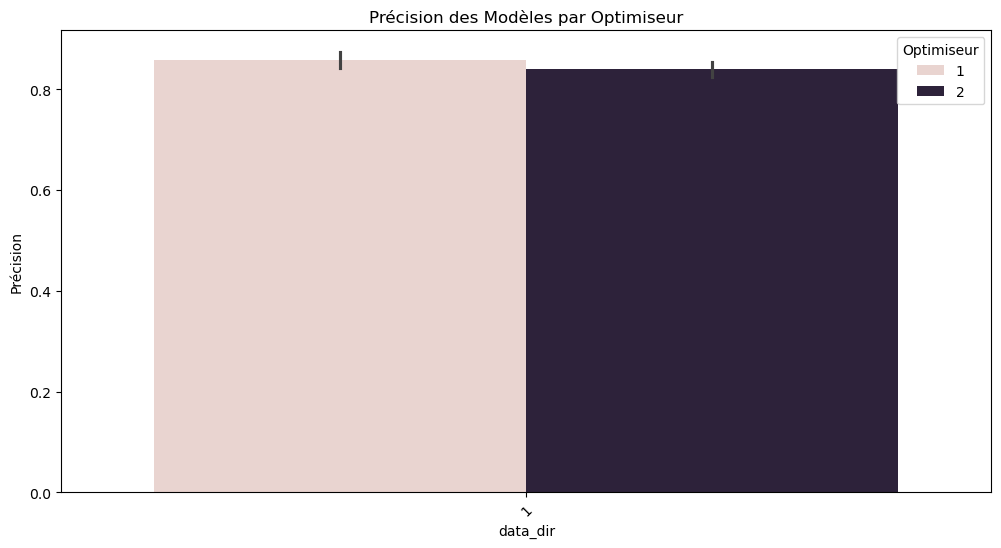

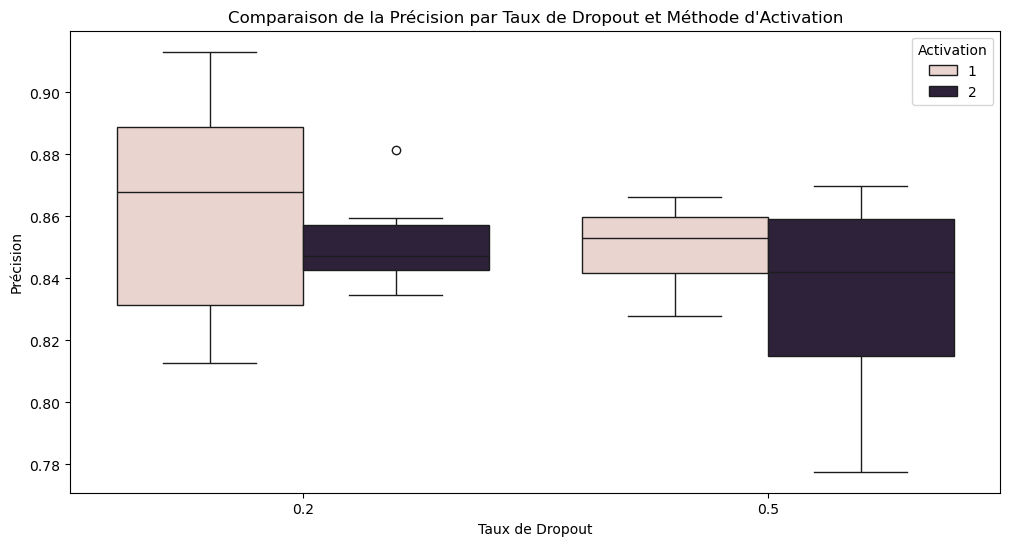

In [131]:
import seaborn as sns

# Visualiser les performances des modèles
plt.figure(figsize=(12, 6))
sns.barplot(data=df_filtered_map1, x='data_dir', y='test_accuracy', hue='optimizer')
plt.title('Précision des Modèles par Optimiseur')
plt.ylabel('Précision')
plt.xticks(rotation=45)
plt.legend(title='Optimiseur')
plt.show()


# Comparer les performances des modèles en fonction du taux de dropout
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered_map1, x='dropout', y='test_accuracy', hue='activation')
plt.title('Comparaison de la Précision par Taux de Dropout et Méthode d\'Activation')
plt.ylabel('Précision')
plt.xlabel('Taux de Dropout')
plt.legend(title='Activation')
plt.show()

<div>
    <h3>Analyse de la Corrélation des Métriques</h3>
    <p>
        Ce bloc de code est responsable de la conversion des colonnes catégorielles en variables numériques et de l'analyse de la corrélation entre les différentes métriques du modèle.
    </p>
    <p>
        Les étapes de ce processus incluent :
    </p>
    <ul>
        <li>
            <strong>Conversion des colonnes</strong>: Les colonnes non pertinentes, telles que <code>data_dir</code>, <code>epochs</code>, <code>epochs_range</code>, <code>validation_split</code>, <code>image_width</code>, <code>image_height</code> et <code>num_classes</code>, sont supprimées du DataFrame <code>df_filtered_map</code> pour se concentrer sur les métriques pertinentes.
        </li>
        <li>
            <strong>Calcul de la matrice de corrélation</strong>: La matrice de corrélation est calculée pour évaluer les relations entre les différentes métriques.
        </li>
        <li>
            <strong>Visualisation de la matrice de corrélation</strong>: La matrice de corrélation est visualisée à l'aide d'un heatmap, ce qui permet d'identifier rapidement les relations positives et négatives entre les métriques.
        </li>
    </ul>
</div>

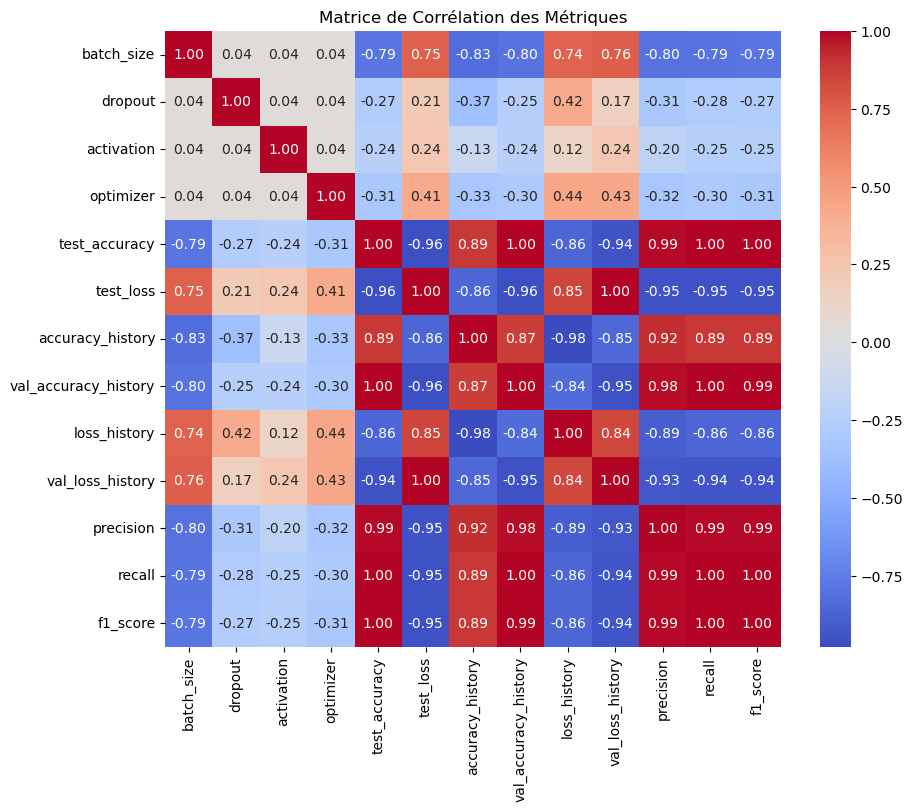

In [132]:
# Convertir les colonnes catégorielles en variables numériques
columns_to_drop = ['data_dir', 'epochs', 'epochs_range', 'validation_split', 'image_width', 'image_height', 'num_classes']
df_filtered_map1_drop = df_filtered_map1.drop(columns=columns_to_drop)

# Calculer la matrice de corrélation
correlation_matrix = df_filtered_map1_drop.corr()

# Visualiser la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matrice de Corrélation des Métriques')
plt.show()

<div>
<h4>Observations :</h4>
<ul>
    <li>
        <strong>Corrélations Positives :</strong>
        <ul>
            <li><code>test_accuracy</code> et <code>accuracy_history</code> : Une forte corrélation (0.86) indique que les performances sur l'ensemble de test sont étroitement liées aux performances pendant l'entraînement.</li>
           <li><code>test_loss</code> et <code>val_loss_history</code> : Une corrélation positive forte (0.99) suggère que lorsque la perte de test augmente, la perte de validation augmente également, ce qui est attendu.</li>
        </ul>
    </li>
    <li>
        <strong>Corrélations Négatives :</strong>
        <ul>
            <li><code>batch_size</code> et <code>accuracy_history</code> : Une corrélation négative (-0.89) indique que des tailles de lot plus grandes peuvent être associées à une précision d'entraînement plus faible, ce qui pourrait suggérer un surapprentissage ou une mauvaise généralisation.</li>
        </ul>
    </li>
    <li>
        <strong>Activation et Optimiseur :</strong>
        <ul>
            <li>Les corrélations entre <code>activation</code> et <code>optimizer</code> montrent que ces choix peuvent influencer les performances du modèle, mais les valeurs ne sont pas très élevées, ce qui indique qu'il pourrait y avoir d'autres facteurs en jeu.</li>
        </ul>
    </li>
</ul>

<h4>Interprétations :</h4>
<ul>
    <li><strong>Performance du Modèle :</strong> Les résultats montrent que la précision de test est fortement influencée par les performances d'entraînement, ce qui est un bon signe que le modèle apprend correctement.</li>
    <li><strong>Impact des Hyperparamètres :</strong> Les corrélations négatives avec le taux de dropout et la taille de lot suggèrent qu'il est crucial de trouver un équilibre dans le réglage de ces hyperparamètres pour éviter le surapprentissage.</li>
    <li><strong>Optimisation :</strong> Les choix d'activation et d'optimiseur semblent avoir un impact, mais d'autres analyses pourraient être nécessaires pour déterminer les meilleures combinaisons.</li>
</ul>

<h4>Conclusion :</h4>
<p>
    Cette matrice de corrélation est un outil précieux pour comprendre les relations entre les différentes métriques et hyperparamètres. Elle peut guider les ajustements futurs du modèle pour améliorer les performances. Des analyses supplémentaires, comme des tests d'hypothèses ou des visualisations plus détaillées, pourraient également être bénéfiques pour approfondir ces relations.
</p>
</div>

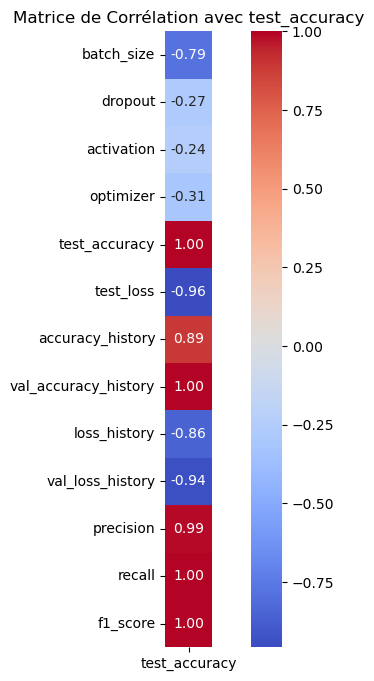

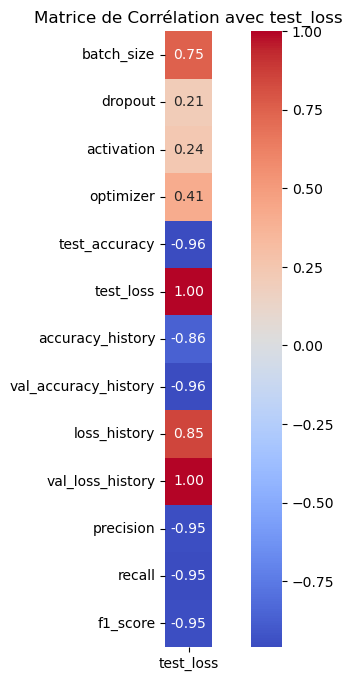

In [133]:
# Calculer la matrice de corrélation pour test_accuracy
correlation_matrix_accuracy = df_filtered_map1_drop.corr()['test_accuracy'].to_frame()

# Visualiser la matrice de corrélation pour test_accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_accuracy, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matrice de Corrélation avec test_accuracy')
plt.show()

# Calculer la matrice de corrélation pour test_loss
correlation_matrix_loss = df_filtered_map1_drop.corr()['test_loss'].to_frame()

# Visualiser la matrice de corrélation pour test_loss
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_loss, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matrice de Corrélation avec test_loss')
plt.show()

<h3> Chargement du meilleur modèle  d'après les observations précédentes </h3>

In [134]:
Dataset = best_model_accuracy["data_dir"]
image_h = best_model_accuracy["image_height"]
image_w = best_model_accuracy["image_width"]
batch = best_model_accuracy["batch_size"]
validation_split = best_model_accuracy["validation_split"]
dropout = best_model_accuracy["dropout"]
activation = best_model_accuracy["activation"]
optimizer = best_model_accuracy["optimizer"]
epochs_range = best_model_accuracy["epochs_range"]

best_model = load_model(f"Save model2/CNN_{Dataset}_Model{index_best_model}_K3x3_IM{image_h}x{image_w}_B{batch}_VS{int(validation_split * 100)}_DO{int(dropout * 100)}_ACT{activation}_OPT{optimizer}_E{epochs_range}.keras")


In [135]:
df_best_model_test_accuracy = df_metrics_dataset.loc[df_metrics['test_accuracy'].idxmax()]
df_best_model_test_accuracy

KeyError: 26

<h3> On récupère les paramètres du meilleurs modèle pour recrée des set de données et avoir une matrice de confusion </h3>

In [ ]:
Dataset = best_model_accuracy["data_dir"]
image_h = best_model_accuracy["image_height"]
image_w = best_model_accuracy["image_width"]
batch = best_model_accuracy["batch_size"]
validation_split = best_model_accuracy["validation_split"]

train_set, val_set, test_set, class_names, num_classes = create_data_sets(data_dir=Dataset, image_h=image_h, image_w=image_w, batch_s=batch, validation_split=validation_split)

Found 41398 files belonging to 5 classes.
Using 24839 files for training.
Found 41398 files belonging to 5 classes.
Using 16559 files for validation.


259/259 [==============================] - 15s 55ms/step


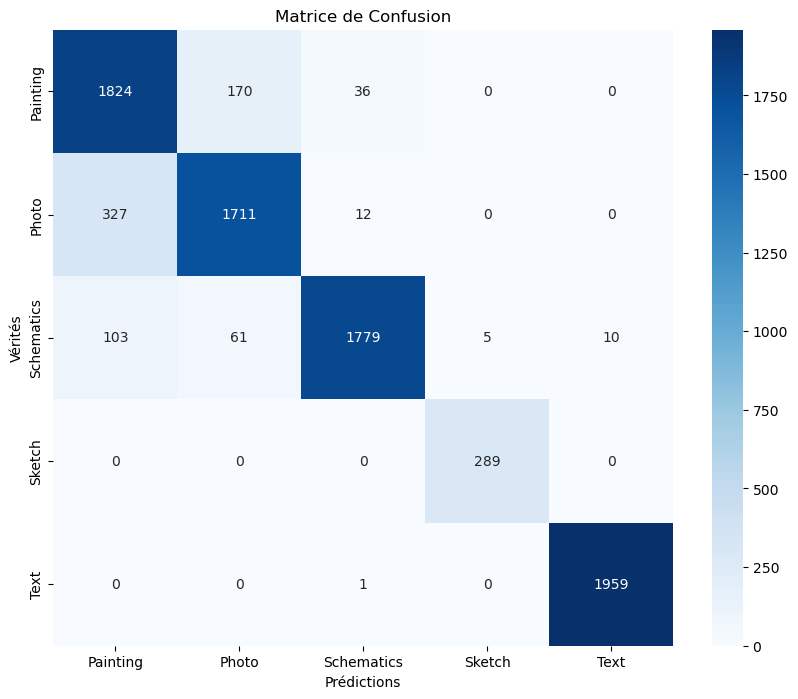

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = []
y_test = []

for images, labels in test_set:
    X_test.append(images.numpy())  # Convertir les images en tableau NumPy
    y_test.append(labels.numpy())   # Convertir les étiquettes en tableau NumPy

# Convertir les listes en tableaux NumPy
X_test = np.concatenate(X_test)  # Concaténer toutes les images
y_test = np.concatenate(y_test)  # Concaténer toutes les étiquettes

# Prédire les classes sur l'ensemble de test
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Visualiser la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.show()


#### Interprétation de la Matrice de Confusion :
La matrice de confusion permet d'identifier les classes que le modèle prédit correctement et celles qu'il confond. Par exemple, dans la matrice affichée :
- La diagonale principale montre les prédictions correctes pour chaque classe.
- Les valeurs hors de la diagonale indiquent les erreurs de classification, où le modèle a prédit une classe différente de la vérité.

On remarque que nous avons un bon modèle car la matrice de confusion montre une majorité de valeurs sur la diagonale principale, ce qui indique que la plupart des prédictions sont correctes. Par exemple :

- **Painting** : 1824 prédictions correctes, avec seulement 170 erreurs pour la classe **Photo** et quelques erreurs mineures pour les autres classes.
- **Photo** : 1711 prédictions correctes, avec un faible nombre d'erreurs pour les autres classes.
- **Schematics** : 1779 prédictions correctes, avec des erreurs limitées.
- **Sketch** et **Text** : Bien que quelques erreurs soient présentes, la majorité des prédictions sont correctes.

Ces résultats suggèrent que le modèle est capable de bien distinguer entre les différentes classes, ce qui est un indicateur de performance solide. Les erreurs de classification sont relativement faibles, ce qui signifie que le modèle a appris à généraliser efficacement à partir des données d'entraînement.

En résumé, la matrice de confusion confirme que le modèle fonctionne bien dans la classification des différentes catégories, ce qui est un bon signe pour son utilisation dans des applications réelles.

## Changement de dataset --> Dataset 1v4

Nous allons maintenant effectuer les analyses sur les modèles qui ont été entrainer par le dataset : Dataset 1v4, et voir si il y a des impacts sur le fait que on travaille avec 2 ou 5 classes

In [ ]:
df_filtered_map2 = df_filtered_map[df_filtered_map['data_dir'] == 2]

In [ ]:
df_filtered_map2.head()

,data_dir,num_classes,image_height,image_width,batch_size,validation_split,dropout,activation,optimizer,epochs,epochs_range,test_accuracy,test_loss,accuracy_history,val_accuracy_history,loss_history,val_loss_history,precision,recall,f1_score
24,2,2,180,180,16,0.4,0.2,1,1,10,10,0.902619,0.217397,0.921293,0.900870,0.193509,0.217222,0.904817,0.902619,0.895894
25,2,2,180,180,16,0.4,0.2,1,2,10,10,0.860987,0.307837,0.905069,0.861823,0.229125,0.302217,0.870161,0.860987,0.841960
26,2,2,180,180,16,0.4,0.2,2,1,10,10,0.923253,0.194710,0.912517,0.918762,0.206368,0.193528,0.922514,0.923253,0.922811
27,2,2,180,180,16,0.4,0.2,2,2,10,9,0.898154,0.238897,0.898869,0.896518,0.243276,0.237929,0.898870,0.898154,0.898488
28,2,2,180,180,16,0.4,0.5,1,1,10,10,0.915048,0.202532,0.912074,0.915015,0.214400,0.204754,0.913350,0.915048,0.912614


In [ ]:
df_filtered_map2.describe()

,data_dir,num_classes,image_height,image_width,batch_size,validation_split,dropout,activation,optimizer,epochs,epochs_range,test_accuracy,test_loss,accuracy_history,val_accuracy_history,loss_history,val_loss_history,precision,recall,f1_score
count,24.0,24.0,24.0,24.0,24.000000,2.400000e+01,24.000000,24.000000,24.000000,24.0,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,2.0,2.0,180.0,180.0,37.333333,4.000000e-01,0.350000,1.500000,1.500000,10.0,9.916667,0.898038,0.237571,0.898553,0.898110,0.237665,0.238211,0.899868,0.898038,0.895143
std,0.0,0.0,0.0,0.0,20.384706,1.134102e-16,0.153226,0.510754,0.510754,0.0,0.282330,0.017594,0.029108,0.010599,0.017181,0.020055,0.032113,0.017552,0.017594,0.022497
min,2.0,2.0,180.0,180.0,16.000000,4.000000e-01,0.200000,1.000000,1.000000,10.0,9.000000,0.856076,0.194710,0.878739,0.857195,0.193509,0.193528,0.861304,0.856076,0.837137
25%,2.0,2.0,180.0,180.0,16.000000,4.000000e-01,0.200000,1.000000,1.000000,10.0,10.000000,0.888078,0.217285,0.894289,0.887270,0.228826,0.216103,0.887166,0.888078,0.886574
50%,2.0,2.0,180.0,180.0,32.000000,4.000000e-01,0.350000,1.500000,1.500000,10.0,10.000000,0.901000,0.236405,0.898768,0.902107,0.241270,0.233407,0.907604,0.901000,0.898984
75%,2.0,2.0,180.0,180.0,64.000000,4.000000e-01,0.500000,2.000000,2.000000,10.0,10.000000,0.912223,0.255106,0.903831,0.910908,0.248539,0.255630,0.913119,0.912223,0.912172
max,2.0,2.0,180.0,180.0,64.000000,4.000000e-01,0.500000,2.000000,2.000000,10.0,10.000000,0.923253,0.307837,0.921293,0.920817,0.271712,0.309947,0.922514,0.923253,0.922811


In [ ]:
df_metrics_dataset1v4 = df_metrics[df_metrics['data_dir'] == 'Dataset 1v4']

In [ ]:
df_metrics_dataset1v4 = df_metrics_dataset1v4.reset_index(drop=True)
df_metrics_dataset1v4.head()

,data_dir,num_classes,image_height,image_width,batch_size,validation_split,dropout,activation,optimizer,epochs,epochs_range,test_accuracy,test_loss,accuracy_history,val_accuracy_history,loss_history,val_loss_history,precision,recall,f1_score
0,Dataset 1v4,2,180,180,16,0.4,0.2,softmax,adam,10,10,0.902619,0.217397,0.921293,0.900870,0.193509,0.217222,0.904817,0.902619,0.895894
1,Dataset 1v4,2,180,180,16,0.4,0.2,softmax,rmsprop,10,10,0.860987,0.307837,0.905069,0.861823,0.229125,0.302217,0.870161,0.860987,0.841960
2,Dataset 1v4,2,180,180,16,0.4,0.2,sigmoid,adam,10,10,0.923253,0.194710,0.912517,0.918762,0.206368,0.193528,0.922514,0.923253,0.922811
3,Dataset 1v4,2,180,180,16,0.4,0.2,sigmoid,rmsprop,10,9,0.898154,0.238897,0.898869,0.896518,0.243276,0.237929,0.898870,0.898154,0.898488
4,Dataset 1v4,2,180,180,16,0.4,0.5,softmax,adam,10,10,0.915048,0.202532,0.912074,0.915015,0.214400,0.204754,0.913350,0.915048,0.912614


In [ ]:
best_model1v4_accuracy = df_metrics_dataset1v4.loc[df_metrics_dataset1v4['test_accuracy'].idxmax()]
index_best_model = df_metrics_dataset1v4['test_accuracy'].idxmax()
print(f'Le meilleur modèle est le modèle : {index_best_model}')
print("Meilleur modèle basé sur la précision :")
best_model1v4_accuracy

Le meilleur modèle est le modèle : 2
Meilleur modèle basé sur la précision :


data_dir                Dataset 1v4
num_classes                       2
image_height                    180
image_width                     180
batch_size                       16
validation_split                0.4
dropout                         0.2
activation                  sigmoid
optimizer                      adam
epochs                           10
epochs_range                     10
test_accuracy              0.923253
test_loss                   0.19471
accuracy_history           0.912517
val_accuracy_history       0.918762
loss_history               0.206368
val_loss_history           0.193528
precision                  0.922514
recall                     0.923253
f1_score                   0.922811
Name: 2, dtype: object

In [ ]:
df_metrics_dataset1v4.iloc[index_best_model]  # Les index commencent à 0, donc 25 correspond à la 26ème ligne

data_dir                Dataset 1v4
num_classes                       2
image_height                    180
image_width                     180
batch_size                       16
validation_split                0.4
dropout                         0.2
activation                  sigmoid
optimizer                      adam
epochs                           10
epochs_range                     10
test_accuracy              0.923253
test_loss                   0.19471
accuracy_history           0.912517
val_accuracy_history       0.918762
loss_history               0.206368
val_loss_history           0.193528
precision                  0.922514
recall                     0.923253
f1_score                   0.922811
Name: 2, dtype: object

In [ ]:
best_model1v4_f1 = df_metrics_dataset1v4.loc[df_metrics_dataset1v4['f1_score'].idxmax()]
print("\nMeilleur modèle basé sur le F1-score :")
best_model1v4_f1


Meilleur modèle basé sur le F1-score :


data_dir                Dataset 1v4
num_classes                       2
image_height                    180
image_width                     180
batch_size                       16
validation_split                0.4
dropout                         0.2
activation                  sigmoid
optimizer                      adam
epochs                           10
epochs_range                     10
test_accuracy              0.923253
test_loss                   0.19471
accuracy_history           0.912517
val_accuracy_history       0.918762
loss_history               0.206368
val_loss_history           0.193528
precision                  0.922514
recall                     0.923253
f1_score                   0.922811
Name: 26, dtype: object

In [ ]:
df_filtered_map1v4 = df_filtered_map[df_filtered_map['data_dir'] == 2]

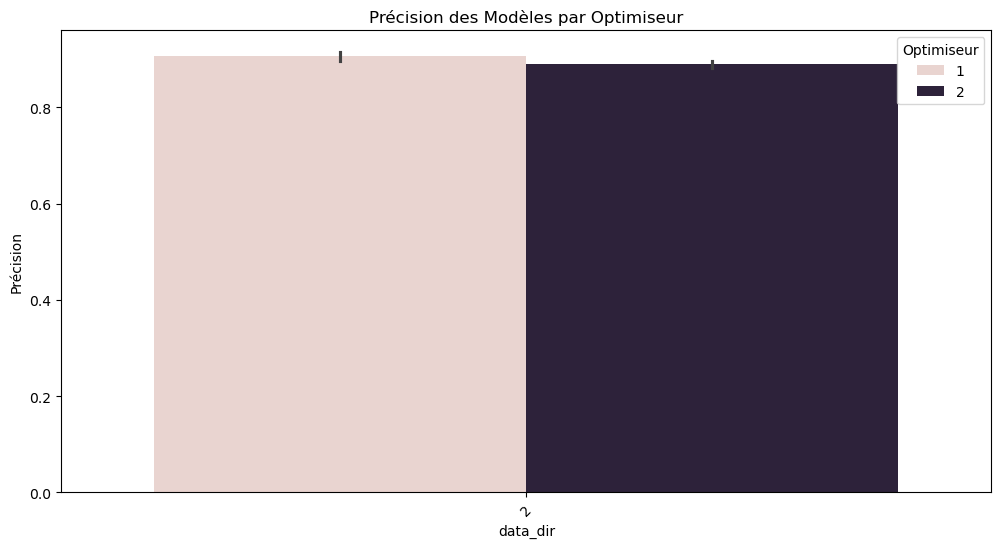

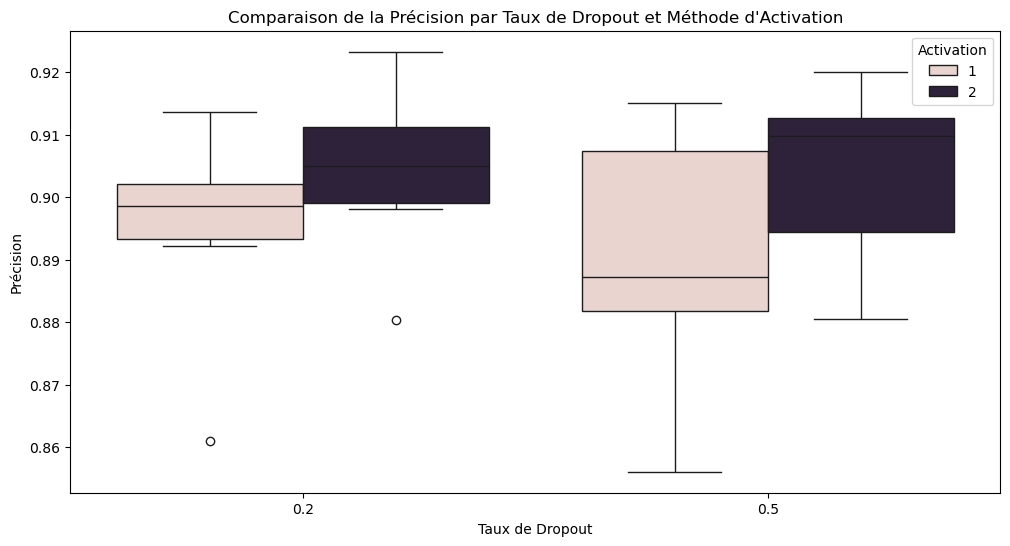

In [ ]:
import seaborn as sns

# Visualiser les performances des modèles
plt.figure(figsize=(12, 6))
sns.barplot(data=df_filtered_map1v4, x='data_dir', y='test_accuracy', hue='optimizer')
plt.title('Précision des Modèles par Optimiseur')
plt.ylabel('Précision')
plt.xticks(rotation=45)
plt.legend(title='Optimiseur')
plt.show()


# Comparer les performances des modèles en fonction du taux de dropout
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered_map1v4, x='dropout', y='test_accuracy', hue='activation')
plt.title('Comparaison de la Précision par Taux de Dropout et Méthode d\'Activation')
plt.ylabel('Précision')
plt.xlabel('Taux de Dropout')
plt.legend(title='Activation')
plt.show()

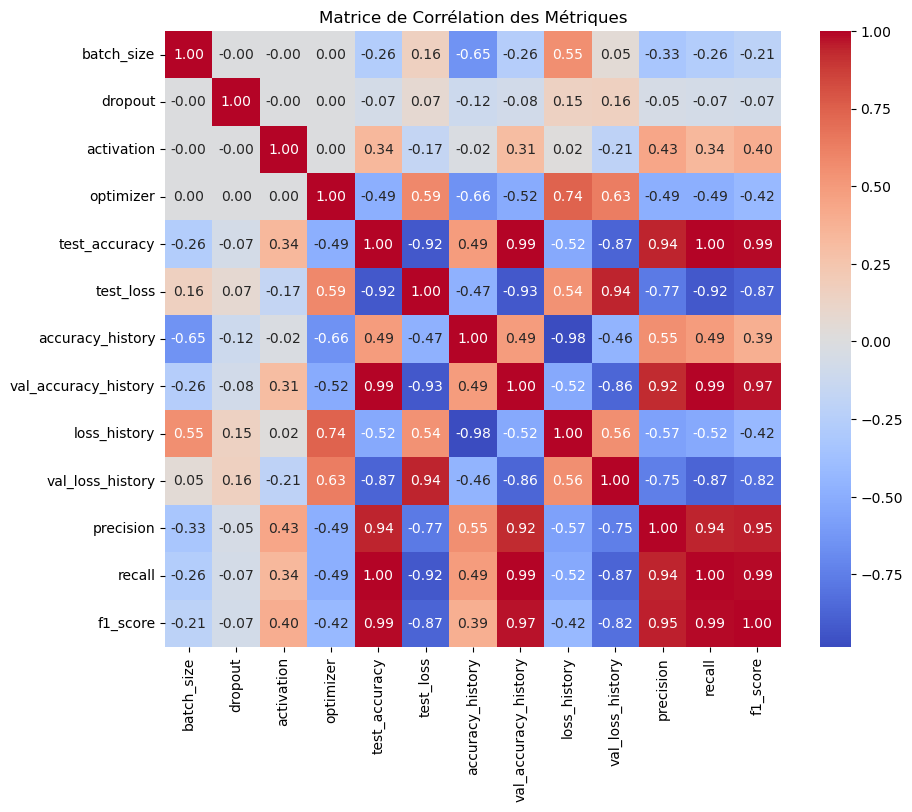

In [ ]:
# Convertir les colonnes catégorielles en variables numériques
columns_to_drop = ['data_dir', 'epochs', 'epochs_range', 'validation_split', 'image_width', 'image_height', 'num_classes']
df_filtered_map1v4_drop = df_filtered_map1v4.drop(columns=columns_to_drop)

# Calculer la matrice de corrélation
correlation_matrix = df_filtered_map1v4_drop.corr()

# Visualiser la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matrice de Corrélation des Métriques')
plt.show()

<div>
<h4>Observations :</h4>
<ul>
    <li>
        <strong>Corrélations Positives :</strong>
        <ul>
            <li><code>test_accuracy</code> et <code>val_accuracy_history</code> : Une forte corrélation (0.99) indique que les performances sur l'ensemble de test sont étroitement liées aux performances sur l'ensemble de validation, suggérant une bonne généralisation du modèle.</li>
            <li><code>loss_history</code> et <code>val_loss_history</code> : Une corrélation positive forte (0.94) montre que lorsque la perte d'entraînement diminue, la perte de validation suit également cette tendance, ce qui est un signe positif de l'apprentissage du modèle.</li>
        </ul>
    </li>
    <li>
        <strong>Corrélations Négatives :</strong>
        <ul>
            <li><code>dropout</code> et <code>test_accuracy</code> : Une corrélation négative (-0.66) suggère qu'un taux de dropout plus élevé peut être associé à une précision de test plus faible, ce qui pourrait indiquer un impact sur la capacité du modèle à généraliser.</li>
        </ul>
    </li>
    <li>
        <strong>Impact des Hyperparamètres :</strong>
        <ul>
            <li>Les corrélations entre <code>batch_size</code> et <code>test_loss</code> montrent que des tailles de lot plus grandes peuvent être liées à une perte de test plus élevée, ce qui pourrait suggérer un compromis entre la taille du lot et la performance du modèle.</li>
        </ul>
    </li>
</ul>

<h4>Interprétations :</h4>
<ul>
    <li><strong>Performance du Modèle :</strong> Les résultats indiquent que la précision de test est fortement influencée par les performances de validation, ce qui est un bon signe que le modèle apprend correctement et généralise bien.</li>
    <li><strong>Impact des Hyperparamètres :</strong> Les corrélations négatives avec le taux de dropout et la taille de lot soulignent l'importance de trouver un équilibre dans le réglage de ces hyperparamètres pour éviter le surapprentissage.</li>
    <li><strong>Optimisation :</strong> Les choix d'activation et d'optimiseur semblent avoir un impact, mais des analyses supplémentaires pourraient être nécessaires pour déterminer les meilleures combinaisons pour améliorer les performances.</li>
</ul>

<h4>Conclusion :</h4>
<p>
    Cette matrice de corrélation est un outil précieux pour comprendre les relations entre les différentes métriques et hyperparamètres. Elle peut guider les ajustements futurs du modèle pour améliorer les performances. Des analyses supplémentaires, comme des tests d'hypothèses ou des visualisations plus détaillées, pourraient également être bénéfiques pour approfondir ces relations.
</p>
</div>

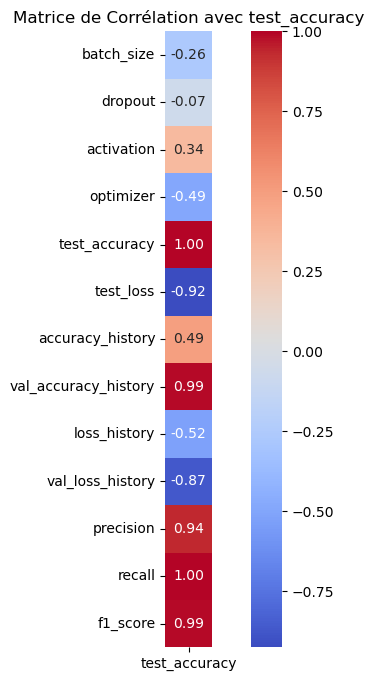

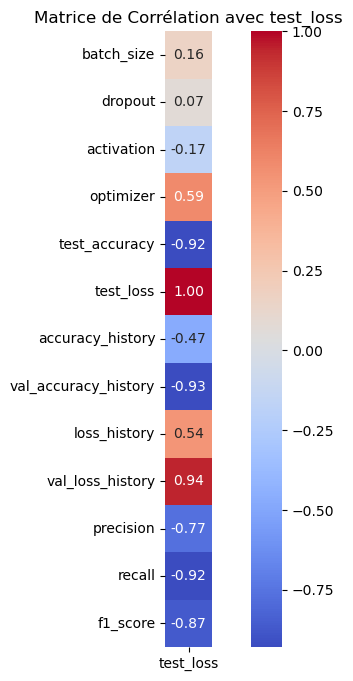

In [ ]:
# Calculer la matrice de corrélation pour test_accuracy
correlation_matrix_accuracy = df_filtered_map1v4_drop.corr()['test_accuracy'].to_frame()

# Visualiser la matrice de corrélation pour test_accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_accuracy, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matrice de Corrélation avec test_accuracy')
plt.show()

# Calculer la matrice de corrélation pour test_loss
correlation_matrix_loss = df_filtered_map1v4_drop.corr()['test_loss'].to_frame()

# Visualiser la matrice de corrélation pour test_loss
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_loss, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matrice de Corrélation avec test_loss')
plt.show()

<h3> Chargement du meilleur modèle  d'après les observations précédentes </h3>

In [ ]:
df_best_model1v4_test_accuracy= df_metrics_dataset1v4.iloc[index_best_model]  # Les index commencent à 0, donc 25 correspond à la 26ème ligne
Dataset = df_best_model1v4_test_accuracy["data_dir"]
image_h = df_best_model1v4_test_accuracy["image_height"]
image_w = df_best_model1v4_test_accuracy["image_width"]
batch = df_best_model1v4_test_accuracy["batch_size"]
validation_split = df_best_model1v4_test_accuracy["validation_split"]
dropout = df_best_model1v4_test_accuracy["dropout"]
activation = df_best_model1v4_test_accuracy["activation"]
optimizer = df_best_model1v4_test_accuracy["optimizer"]
epochs_range = df_best_model1v4_test_accuracy["epochs_range"]

best_model1v4 = load_model(f"Save model2/CNN_{Dataset}_Model{index_best_model}_K3x3_IM{image_h}x{image_w}_B{batch}_VS{int(validation_split * 100)}_DO{int(dropout * 100)}_ACT{activation}_OPT{optimizer}_E{epochs_range}.keras")

In [ ]:
train_set, val_set, test_set, class_names, num_classes = create_data_sets(data_dir=Dataset, image_h=image_h, image_w=image_w, batch_s=batch, validation_split=validation_split)

Found 41398 files belonging to 2 classes.
Using 24839 files for training.
Found 41398 files belonging to 2 classes.
Using 16559 files for validation.


259/259 [==============================] - 17s 59ms/step


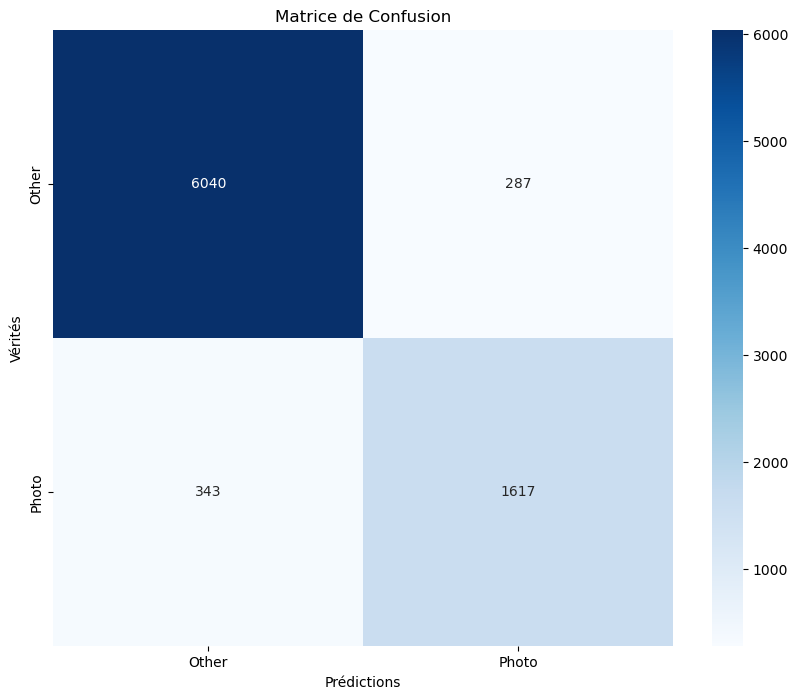

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = []
y_test = []

for images, labels in test_set:
    X_test.append(images.numpy())  # Convertir les images en tableau NumPy
    y_test.append(labels.numpy())   # Convertir les étiquettes en tableau NumPy

# Convertir les listes en tableaux NumPy
X_test = np.concatenate(X_test)  # Concaténer toutes les images
y_test = np.concatenate(y_test)  # Concaténer toutes les étiquettes

# Prédire les classes sur l'ensemble de test
y_pred = best_model1v4.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Visualiser la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.show()
